In [52]:
# === SECTION 1: Imports and Configuration ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import norm
from scipy.interpolate import griddata, interp1d
from sklearn.linear_model import LassoCV

# Configuration
TRADING_DAYS_PER_MONTH = 21
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [53]:
df_1m_filtered = pd.read_csv('FilteredDataset.csv', index_col=0)
df_1m_filtered['date'] = pd.to_datetime(df_1m_filtered['date'])
df_1m_filtered['exdate'] = pd.to_datetime(df_1m_filtered['exdate'])
print(f"\nFinal filtered dataset: {len(df_1m_filtered)} rows")
df_1m_filtered.head(10)


Final filtered dataset: 28073947 rows


,date,exdate,cp_flag,strike_price,spot,moneyness,dte,mid,best_bid,best_offer,volume,open_interest,delta,vega,impl_volatility,spread,rel_spread
0,2000-01-03,2000-01-22,P,1275.0,1455.22,0.876156,19,2.0000,1.750,2.250,585,23785,-0.041295,28.57753,0.358787,0.500,0.250000
1,2000-01-03,2000-01-22,P,1300.0,1455.22,0.893336,19,2.6250,2.250,3.000,3572,26621,-0.055490,36.20153,0.334738,0.750,0.285714
2,2000-01-03,2000-01-22,P,1325.0,1455.22,0.910515,19,3.8125,3.500,4.125,1406,30757,-0.079749,47.92918,0.317378,0.625,0.163934
3,2000-01-03,2000-01-22,C,1325.0,1455.22,0.910515,19,134.5000,133.500,135.500,315,29529,0.983012,13.61578,0.207545,2.000,0.014870
4,2000-01-03,2000-01-22,C,1350.0,1455.22,0.927695,19,111.1250,110.125,112.125,112,20500,0.939732,38.63064,0.229941,2.000,0.017998
5,2000-01-03,2000-01-22,P,1350.0,1455.22,0.927695,19,5.1875,4.875,5.500,819,24413,-0.109956,60.74824,0.294041,0.625,0.120482
6,2000-01-03,2000-01-22,C,1375.0,1455.22,0.944874,19,88.5000,87.500,89.500,6,7885,0.884385,62.96457,0.229135,2.000,0.022599
7,2000-01-03,2000-01-22,P,1375.0,1455.22,0.944874,19,6.9375,6.750,7.125,2633,18270,-0.150684,75.57642,0.267472,0.375,0.054054
8,2000-01-03,2000-01-22,C,1380.0,1455.22,0.948310,19,84.0000,83.000,85.000,4,13,0.872528,67.43791,0.226489,2.000,0.023810
9,2000-01-03,2000-01-22,P,1380.0,1455.22,0.948310,19,8.1250,7.625,8.625,69,1458,-0.168821,81.41239,0.271506,1.000,0.123077


In [54]:
df_spot = pd.read_csv(OM_UNDERLYING_CSV)
df_spot['date'] = pd.to_datetime(df_spot['date'])
df_spot = df_spot[df_spot['ticker'] == 'SPX'][['date', 'close']].rename(columns={'close': 'spot'})
df_spot = df_spot.drop_duplicates('date').sort_values('date')
df_underlying = df_spot

In [55]:
surf_df = pd.read_csv("surfacesTransform.csv", index_col="date")

# Extract as numpy array
surfaces_transform = surf_df.values
dates_volgan = pd.to_datetime(surf_df.index)

print(f"Loaded surfacesTransform.csv with shape: {surfaces_transform.shape}")
print(f"Date range: {dates_volgan[0].date()} → {dates_volgan[-1].date()}")
m = np.linspace(0.6, 1.4, 10)
dte_grid = [7, 14, 30, 60, 91, 122, 152, 182]
tau = np.array(dte_grid) / 365.0



Loaded surfacesTransform.csv with shape: (5954, 80)
Date range: 2000-01-03 → 2023-08-31


In [56]:
import torch
import numpy as np
import random

def set_all_seeds(seed=42):
    """Set seeds for complete reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Make cudnn deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# At the VERY START of your script (before any imports of VolGAN):
set_all_seeds(42)


In [57]:
# === SECTION 5: Prepare VolGAN Training Data ===

def prepare_volgan_data_om(surfaces, dates_list, df_spot):
    """Prepare condition and target arrays for VolGAN."""
    dates_pd = pd.to_datetime(dates_list)
    spot_df = df_spot[df_spot['date'].isin(dates_pd)].sort_values('date')
    prices = spot_df['spot'].values
    
    # Log returns
    prices_prev = np.zeros(len(prices))
    prices_prev[1:] = prices[:-1]
    prices_prev[0] = prices[0]
    log_rtn = np.log(prices) - np.log(prices_prev)
    
    # Realized volatility (21-day rolling)
    realised_vol_tm1 = np.zeros(len(log_rtn) - 22)
    for i in range(len(realised_vol_tm1)):
        realised_vol_tm1[i] = np.sqrt(252 / 21) * np.sqrt(np.sum(log_rtn[i:(i+21)]**2))
    print("i am using daily")
    # Align dates
    dates_t = dates_pd[22:]
    log_rtn_t = log_rtn[22:]
    log_rtn_tm1 = log_rtn[21:-1]
    log_rtn_tm2 = log_rtn[20:-2]
    
    # Log IV surfaces
    log_iv_t = np.log(surfaces[22:])
    log_iv_tm1 = np.log(surfaces[21:-1])
    log_iv_inc_t = log_iv_t - log_iv_tm1
    
    # Condition: [r_{t-1}, r_{t-2}, RV_{t-1}, log_iv_{t-1}]
    condition = np.concatenate((
        np.expand_dims(log_rtn_tm1, axis=1),
        np.expand_dims(log_rtn_tm2, axis=1),
        np.expand_dims(realised_vol_tm1, axis=1),
        log_iv_tm1
    ), axis=1)
    
    # Target: [r_t, log_iv_inc_t]
    log_rtn_t_daily = log_rtn_t
    true = np.concatenate((
        np.expand_dims(log_rtn_t_daily, axis=1),
        log_iv_inc_t
    ), axis=1)
    
    return true, condition, dates_t

true, condition, dates_volgan_aligned = prepare_volgan_data_om(
    surfaces_transform, dates_volgan, df_underlying
)
print(f"VolGAN data shapes: true={true.shape}, condition={condition.shape}")
# After prepare_volgan_data_om:
print("Sample condition features:")
print(f"  r_tm1: mean={condition[:, 0].mean():.4f}, std={condition[:, 0].std():.4f}")
print(f"  RV_tm1: mean={condition[:, 2].mean():.4f}, std={condition[:, 2].std():.4f}")
print(f"  log_iv_tm1: mean={condition[:, 3:].mean():.4f}, std={condition[:, 3:].std():.4f}")

print("Sample targets:")
print(f"  r_t: mean={true[:, 0].mean():.4f}, std={true[:, 0].std():.4f}")
print(f"  log_iv_inc: mean={true[:, 1:].mean():.4f}, std={true[:, 1:].std():.4f}")

i am using daily
VolGAN data shapes: true=(5932, 81), condition=(5932, 83)
Sample condition features:
  r_tm1: mean=0.0002, std=0.0124
  RV_tm1: mean=0.1657, std=0.1072
  log_iv_tm1: mean=-1.3691, std=0.5898
Sample targets:
  r_t: mean=0.0002, std=0.0124
  log_iv_inc: mean=-0.0000, std=0.4303


In [58]:
# === SECTION 5B: Train/Test Split for VolGAN Training ===

# Define train/test cutoff test 2017 to 2020, 500 epochs
train_end = pd.Timestamp('2019-12-31')
dates_pd = pd.to_datetime(dates_volgan_aligned)

# Create masks
train_mask = dates_pd <= train_end
test_mask = dates_pd > train_end

# Convert to tensors and split
true_train = torch.tensor(true[train_mask], dtype=torch.float, device=device)
true_test = torch.tensor(true[test_mask], dtype=torch.float, device=device)
condition_train = torch.tensor(condition[train_mask], dtype=torch.float, device=device)
condition_test = torch.tensor(condition[test_mask], dtype=torch.float, device=device)

print(f"Training data split:")
print(f"  - Train samples: {true_train.shape[0]} (dates up to {train_end.date()})")
print(f"  - Test samples: {true_test.shape[0]} (dates after {train_end.date()})")
print(f"  - Condition dim: {condition_train.shape[1]}")
print(f"  - Target dim: {true_train.shape[1]}")

Training data split:
  - Train samples: 5009 (dates up to 2019-12-31)
  - Test samples: 923 (dates after 2019-12-31)
  - Condition dim: 83
  - Target dim: 81


In [59]:
class Generator(nn.Module):
    '''
    VolGAN generator
    Generator Class
    Values:
        noise_dim: the dimension of the noise, a scalar
        cond_dim: the dimension of the condition, a scalar
        hidden_dim: the inner dimension, a scalar
        output_dim: output dimension, a scalar
    '''
    def __init__(self, noise_dim,cond_dim, hidden_dim,output_dim, mean_in = False, std_in = False, mean_out = False, std_out = False):
        super(Generator, self).__init__()
        self.input_dim = noise_dim+cond_dim
        self.cond_dim = cond_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.noise_dim = noise_dim
        self.mu_i = mean_in
        self.std_i = std_in
        self.mu_o = mean_out
        self.std_o = std_out

        #Add the modules
   
        self.linear1 = nn.Linear(in_features = self.input_dim, out_features = self.hidden_dim)
        self.linear2 = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim * 2)
        self.linear3 = nn.Linear(in_features = self.hidden_dim * 2, out_features = self.output_dim)
        self.activation1 = nn.Softplus()
        self.activation2 = nn.Softplus()
        # self.activation3 = nn.Sigmoid()
       

    def forward(self, noise,condition):
        '''
        Function for completing a forward pass of the generator:adding the noise and the condition separately
        '''
        #x = combine_vectors(noise.to(torch.float),condition.to(torch.float),2)
        #condition: S_t-1, sigma_t-1, r_t-1, implied vol_t-1
        #out: increment in r_t, increment in implied vol _t
        
        # condition = (condition - self.mu_i) / self.std_i
        out = torch.cat([noise,condition],dim=-1).to(torch.float)
        out = self.linear1(out)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        out = self.linear3(out)
        #uncomment to normalise
        # out = self.mu_o + self.std_o * out
        # out = torch.max(out,torch.tensor(10**(-5)))
        
        return out

class Discriminator(nn.Module):
    '''
    VolGAN discriminator
      in_dim: the input dimension (concatenated with the condition), a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, in_dim, hidden_dim, mean = False, std = False):
        super(Discriminator, self).__init__()
        self.input_dim = in_dim
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(in_features=self.input_dim, out_features= self.hidden_dim)
        self.linear2 = nn.Linear(in_features = self.hidden_dim, out_features = 1)
        self.sigmoid = nn.Sigmoid()
        self.Softplus = nn.Softplus()
        self.mu_i = mean
        self.std_i = std

       


    def forward(self, in_chan):
        '''
        in_chan: concatenated condition with real or fake
        h_0 and c_0: for the LSTM
        '''
        x = in_chan
        #uncomment to normalise
        # x = (x - self.mu_i) / self.std_i
        out = self.linear1(x)
        out = self.Softplus(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out


In [60]:
# === SECTION 7: Black-Scholes Pricing Functions ===

def BS_call(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*tau)

def BS_put(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return K*norm.cdf(-d2)*np.exp(-r*tau) - S*norm.cdf(-d1)

In [61]:
from sklearn.linear_model import Ridge
import warnings
import numpy as np
import pandas as pd
import torch
from scipy.interpolate import interp1d

def hedge_with_volgan(gen, condition_t, spot_t, K_straddle, hedge_options, 
                      m_grid, tau_grid, true_mean, true_std, n_scenarios=1000, device='cpu'):
    """
    Simplified VolGAN hedging function.
    
    Args:
        gen: Trained generator network
        condition_t: Current market condition tensor
        spot_t: Current spot price
        K_straddle: Strike price of straddle to hedge
        hedge_options: List of hedge instruments, e.g., [{'cp': 'C', 'K': 3330}, ...]
        m_grid: Moneyness grid
        tau_grid: Time-to-maturity grid
        n_scenarios: Number of scenarios to generate
        device: 'cpu' or 'cuda'
    
    Returns:
        hedge_ratios: Dict of instrument names to hedge ratios
    """
    gen.eval()
    
    # Generate scenarios
    with torch.no_grad():
        noise = torch.randn((n_scenarios, gen.noise_dim), device=device)
        condition_batch = condition_t.unsqueeze(0).repeat(n_scenarios, 1)
        fake = gen(noise, condition_batch)
        fake = fake * true_std + true_mean
        
        spot_ret_scenarios = fake[:, 0].cpu().numpy()
        log_iv_inc_scenarios = fake[:, 1:].cpu().numpy()
    
    # Compute future spot prices
    spot_t1_scenarios = spot_t * np.exp(spot_ret_scenarios)
    
    # Current IV surface
    iv_current = np.exp(condition_t[3:].cpu().numpy())
    n_m, n_tau = len(m_grid), len(tau_grid)
    tau_straddle = 21 / 365
    
    # === Compute straddle values at t+1 ===
    V_t1_scenarios = []
    for i in range(n_scenarios):
        S_t1 = spot_t1_scenarios[i]
        iv_t1_flat = iv_current * np.exp(log_iv_inc_scenarios[i])
        iv_surface = iv_t1_flat.reshape(n_tau, n_m).T
        
        # Interpolate IV for straddle
        m_straddle = np.clip(K_straddle / S_t1, m_grid[0], m_grid[-1])
        try:
            iv_at_tau = interp1d(tau_grid, iv_surface, axis=1,
                                bounds_error=False, fill_value='extrapolate')(tau_straddle)
            iv_interp = np.clip(np.interp(m_straddle, m_grid, iv_at_tau), 0.05, 2.0)
        except:
            iv_interp = 0.25
        
        # Price straddle
        V_call = BS_call(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_put = BS_put(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_t1_scenarios.append(V_call + V_put)
    
    V_t1_scenarios = np.array(V_t1_scenarios)
    
    # === Compute current straddle value ===
    iv_surface_t = iv_current.reshape(n_tau, n_m).T
    m_straddle_t = np.clip(K_straddle / spot_t, m_grid[0], m_grid[-1])
    
    try:
        iv_at_tau_t = interp1d(tau_grid, iv_surface_t, axis=1,
                              bounds_error=False, fill_value='extrapolate')(tau_straddle)
        iv_t = np.clip(np.interp(m_straddle_t, m_grid, iv_at_tau_t), 0.05, 2.0)
    except:
        iv_t = 0.25
    
    V_t = BS_call(spot_t, tau_straddle, K_straddle, iv_t, r=0) + \
          BS_put(spot_t, tau_straddle, K_straddle, iv_t, r=0)
    
    # Target: change in straddle value
    y = V_t1_scenarios - V_t
    
    # === Compute hedge instrument changes ===
    H_changes = {}
    
    # Spot change
    H_changes['spot'] = spot_t1_scenarios - spot_t
    
    # Option changes
    for opt in hedge_options:
        H_t1_values = []
        for i in range(n_scenarios):
            S_t1 = spot_t1_scenarios[i]
            iv_t1_flat = iv_current * np.exp(log_iv_inc_scenarios[i])
            iv_surface = iv_t1_flat.reshape(n_tau, n_m).T
            
            m_opt = np.clip(opt['K'] / S_t1, m_grid[0], m_grid[-1])
            try:
                iv_at_tau = interp1d(tau_grid, iv_surface, axis=1,
                                    bounds_error=False, fill_value='extrapolate')(tau_straddle)
                iv_opt = np.clip(np.interp(m_opt, m_grid, iv_at_tau), 0.05, 2.0)
            except:
                iv_opt = 0.25
            
            if opt['cp'] == 'C':
                H_t1 = BS_call(S_t1, tau_straddle, opt['K'], iv_opt, r=0)
            else:
                H_t1 = BS_put(S_t1, tau_straddle, opt['K'], iv_opt, r=0)
            
            H_t1_values.append(H_t1)
        
        H_t1_values = np.array(H_t1_values)
        
        # Current option value
        m_opt_t = np.clip(opt['K'] / spot_t, m_grid[0], m_grid[-1])
        try:
            iv_opt_t = np.clip(np.interp(m_opt_t, m_grid, iv_at_tau_t), 0.05, 2.0)
        except:
            iv_opt_t = 0.25
        
        if opt['cp'] == 'C':
            H_t = BS_call(spot_t, tau_straddle, opt['K'], iv_opt_t, r=0)
        else:
            H_t = BS_put(spot_t, tau_straddle, opt['K'], iv_opt_t, r=0)
        
        # Change in option value
        H_changes[f"{opt['cp']}_{opt['K']}"] = H_t1_values - H_t
    
    # === Regression ===
    X = pd.DataFrame(H_changes)
    
    # Check for issues
    if X.isna().any().any() or np.isinf(X).any().any():
        return {k: 0.0 for k in X.columns}
    
    # Standardize
    X_mean = X.mean()
    X_std = X.std()
    X_std[X_std < 1e-6] = 1.0
    X_scaled = (X - X_mean) / X_std
    
    # Ridge regression
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ridge = Ridge(alpha=1.0, fit_intercept=False)
        ridge.fit(X_scaled, y)
        r2 = ridge.score(X_scaled, y)
    
    # Unstandardize coefficients
    coef_unstandardized = ridge.coef_ / X_std.values
    hedge_ratios = {instr: coef for instr, coef in zip(X.columns, coef_unstandardized)}
    
    # Handle poor fits
    if r2 < -1:
        return {k: 0.0 for k in hedge_ratios.keys()}
    
    if r2 < 0.5:
        scale = max(r2 / 0.5, 0.1)
        hedge_ratios = {k: v * scale for k, v in hedge_ratios.items()}
    
    # Cap individual hedges
    MAX_HEDGE = 5.0
    for key in hedge_ratios:
        if abs(hedge_ratios[key]) > MAX_HEDGE:
            hedge_ratios[key] = np.sign(hedge_ratios[key]) * MAX_HEDGE
    
    # Cap total hedge size
    total_hedge = sum(abs(v) for v in hedge_ratios.values())
    if total_hedge > 15:
        scale = 15 / total_hedge
        hedge_ratios = {k: v * scale for k, v in hedge_ratios.items()}
    
    return hedge_ratios


In [62]:
# After prepare_volgan_data_om:
print("Sample condition features:")
print(f"  r_tm1: mean={condition_train[:, 0].mean():.4f}, std={condition_train[:, 0].std():.4f}")
print(f"  RV_tm1: mean={condition_train[:, 2].mean():.4f}, std={condition_train[:, 2].std():.4f}")
print(f"  log_iv_tm1: mean={condition_train[:, 3:].mean():.4f}, std={condition_train[:, 3:].std():.4f}")

print("Sample targets:")
print(f"  r_t: mean={true[:, 0].mean():.4f}, std={true[:, 0].std():.4f}")
print(f"  log_iv_inc: mean={true[:, 1:].mean():.4f}, std={true[:, 1:].std():.4f}")

Sample condition features:
  r_tm1: mean=0.0002, std=0.0119
  RV_tm1: mean=0.1601, std=0.1003
  log_iv_tm1: mean=-1.3925, std=0.5917
Sample targets:
  r_t: mean=0.0002, std=0.0124
  log_iv_inc: mean=-0.0000, std=0.4303


In [63]:
# === SECTION 9: Utility Functions for Backtest ===

def get_window_dates(df_all, start_idx):
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        return None
    return list(dates[start_idx:start_idx + TRADING_DAYS_PER_MONTH + 1])

def choose_strike_for_m0(spot0, m0, strikes):
    target = m0 * spot0
    return float(strikes[np.abs(strikes - target).argmin()])

def pick_one(day_df, strike, cp_flag):
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        return None
    sub = sub.dropna(subset=['mid', 'delta', 'vega'])
    sub = sub[sub['best_offer'] >= sub['best_bid']]
    if sub.empty:
        return None
    sub = sub.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return sub.iloc[0]

def fetch_next_row(next_df, strike, cp_flag):
    nxt = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)]
    if nxt.empty:
        return None
    nxt = nxt.dropna(subset=['mid'])
    nxt = nxt.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return nxt.iloc[0]

In [64]:
# === SECTION 10: Single Window Runner ===

def run_volgan_window(df_all, gen, start_idx, m0, m_grid, tau_grid, true_mean, true_std,
                      condition_data, dates_data, device='cpu'):
    """Run one 21-day VolGAN hedging window."""
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0]
    if day0.empty:
        return None
    
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    
    hedge_options = [
        {'K': K_straddle, 'cp': 'C'},
        {'K': K_straddle, 'cp': 'P'},
        {'K': K_straddle * 0.9, 'cp': 'P'},
        {'K': K_straddle * 1.1, 'cp': 'C'},
    ]
    
    records = []
    V0, Pi_t = None, None
    phi_prev = {}
    
    for t in range(len(days) - 1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t + 1])
        
        day = df_all[df_all['date'] == d]
        day_next = df_all[df_all['date'] == d_next]
        
        if day.empty or day_next.empty:
            return None
        
        row_C = pick_one(day, K_straddle, 'C')
        row_P = pick_one(day, K_straddle, 'P')
        if row_C is None or row_P is None:
            return None
        
        V_t = row_C['mid'] + row_P['mid']
        spot_t = row_C['spot']
        
        if V0 is None:
            V0 = V_t
            Pi_t = V0
        
        # Get VolGAN condition
        try:
            date_idx = np.where(dates_data == d)[0][0]
            condition_t = torch.tensor(condition_data[date_idx], dtype=torch.float, device=device)
        except (IndexError, ValueError):
            return None
        
        hedge_ratios = hedge_with_volgan(
            gen, condition_t, spot_t, K_straddle, hedge_options, true_mean=true_mean.to(device),  # <- Add
            true_std=true_std.to(device), 
            m_grid=m_grid, tau_grid=tau_grid, n_scenarios=100, device=device
        )
        if hedge_ratios is None:
            return None
    
        # NEW: Sanity check on hedge ratios
        total_abs_hedge = sum(abs(v) for v in hedge_ratios.values())
        if total_abs_hedge > 20:  # Sum of absolute hedges shouldn't exceed 20
            print(f"⚠️ Suspicious hedges at {d}: total = {total_abs_hedge:.2f}")
            # Use simpler hedge (e.g., delta-only)
            hedge_ratios = {'spot': 0.0}  # Minimal hedge for straddle
            for key in hedge_ratios:
                if key != 'spot':
                    hedge_ratios[key] = 0.0
        
        row_C_next = fetch_next_row(day_next, K_straddle, 'C')
        row_P_next = fetch_next_row(day_next, K_straddle, 'P')
        if row_C_next is None or row_P_next is None:
            return None
        
        spot_t1 = row_C_next['spot']
        V_t1 = row_C_next['mid'] + row_P_next['mid']
        
        pnl_total = 0
        cost_total = 0
        
        phi_spot = hedge_ratios.get('spot', 0)
        pnl_total += phi_spot * (spot_t1 - spot_t)
        
        for opt in hedge_options:
            key = f"{opt['cp']}_{opt['K']}"
            phi_opt = hedge_ratios.get(key, 0)
            
            opt_t = pick_one(day, opt['K'], opt['cp'])
            opt_t1 = fetch_next_row(day_next, opt['K'], opt['cp'])
            
            if opt_t is not None and opt_t1 is not None:
                pnl_total += phi_opt * (opt_t1['mid'] - opt_t['mid'])
                phi_opt_prev = phi_prev.get(key, 0)
                cost_total += abs(phi_opt - phi_opt_prev) * (opt_t['best_offer'] - opt_t['best_bid']) / 2.0
        
        Pi_t1 = Pi_t + pnl_total - cost_total
        
        records.append({
            'date': d,
            'V_t': V_t,
            'Pi_t': Pi_t,
            'Pi_t1': Pi_t1,
            'pnl_hedged': pnl_total - cost_total,
            'pnl_unhedged': V_t1 - V_t
        })
        
        phi_prev = hedge_ratios.copy()
        Pi_t = Pi_t1
    
    # Final valuation
    last_day, final_day = pd.Timestamp(days[-2]), pd.Timestamp(days[-1])
    day_last = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]
    
    row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    
    if row_C_fin is None or row_P_fin is None:
        return None
    
    V_T = row_C_fin['mid'] + row_P_fin['mid']
    Pi_T = records[-1]['Pi_t1']
    
    summary = {
        'start': days[0],
        'end': days[-1],
        'm0': m0,
        'V0': V0,
        'V_T': V_T,
        'Pi_T': Pi_T,
        'tracking_error': V_T - Pi_T,
        'pnl_unhedged': V_T - V0,
        'pnl_hedged': Pi_T - V0,
        'strategy': 'VolGAN'
    }
    
    return {'timeline': pd.DataFrame(records), 'summary': summary}

In [65]:
# === SECTION 11: Multi-Window Experiment ===

def run_volgan_experiment(df_all, gen, m0_list, condition_data, dates_data, true_mean, true_std,
                          m_grid, tau_grid, max_windows=52, device='cpu'):
    """Run VolGAN across multiple windows."""
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]
    
    results = []
    for m0 in m0_list:
        print(f"\n===== VolGAN: m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"Window {i}/{len(start_indices)}")
            out = run_volgan_window(
                df_all, gen, si, m0, m_grid, tau_grid, true_mean, true_std,
                condition_data, dates_data, device
            )
            if out is not None:
                results.append(out['summary'])
    
    return pd.DataFrame(results)

In [66]:
start_backtest = pd.Timestamp("2020-01-01")
df_1m_bt = df_1m_filtered[df_1m_filtered['date'] >= start_backtest]
print(f"Backtest  {len(df_1m_bt)} rows from {df_1m_bt['date'].min()} to {df_1m_bt['date'].max()}")

Backtest  14429467 rows from 2020-01-02 00:00:00 to 2023-08-31 00:00:00


In [67]:
# === SECTION 13: Filter Test Data for VolGAN ===

# Define train/test split
train_end = pd.Timestamp('2020-01-01')
dates_pd = pd.to_datetime(dates_volgan_aligned)
test_mask = dates_pd > train_end

# Extract test data
condition_test_raw = condition[test_mask]
dates_test_raw = dates_pd[test_mask]

# Filter to overlap with backtest dates
dates_in_backtest = df_1m_bt['date'].unique()
mask_overlap = np.isin(dates_test_raw, dates_in_backtest)

condition_test_filtered = condition_test_raw[mask_overlap]
dates_test_filtered = dates_test_raw[mask_overlap]

print(f"VolGAN test  {len(dates_test_filtered)} dates")
print(f"Coverage: {dates_test_filtered.min()} to {dates_test_filtered.max()}")

VolGAN test  923 dates
Coverage: 2020-01-02 00:00:00 to 2023-08-31 00:00:00


In [113]:
# === SECTION 13A: Initialize Models ===

# Dimensions
# noise_dim = 20
# cond_dim = 3 + 80  # 3 (r_tm1, r_tm2, RV_tm1) + 80 (log IV surface)
# hidden_dim = 128
# output_dim = 1 + 80  # 1 (spot return) + 80 (log IV increment)

tr = 0.85
noise_dim = 32
hidden_dim = 128
device = 'cpu'
n_epochs = 10000
n_grad = 25
val = True
mu_o = true_train.mean(dim=0)  # Mean for each output dimension
std_o = true_train.std(dim=0)  # Std for each output dimension

# Before training: Normalize targets
true_mean = true_train.mean(dim=0)
true_std = true_train.std(dim=0)
true_std = torch.clamp(true_std, min=1e-4)

true_train_normalized = (true_train - true_mean) / true_std

print("Training data normalization:")
print(f"  Original - mean: {true_train.mean():.4f}, std: {true_train.std():.4f}")
print(f"  Normalized - mean: {true_train_normalized.mean():.4f}, std: {true_train_normalized.std():.4f}")

# Initialize generator and discriminator
gen = Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[1], 
                      hidden_dim=hidden_dim,output_dim=true_train.shape[1], mean_out = False, std_out =False)
disc = Discriminator(in_dim = condition_train.shape[1] + true_train.shape[1], hidden_dim = hidden_dim)

gen.to(device)
disc.to(device)

print(f"Generator parameters: {sum(p.numel() for p in gen.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters()):,}")

Training data normalization:
  Original - mean: -0.0000, std: 0.4420
  Normalized - mean: 0.0000, std: 0.9999
Generator parameters: 68,689
Discriminator parameters: 21,249


In [107]:
import torch
import numpy as np
from tqdm import tqdm

def GradientMatching_simple(gen, gen_opt, disc, disc_opt, criterion, 
                            condition_train, true_train, m, tau, n_grad, 
                            batch_size, noise_dim, device, lk=10, lt=8):
    """
    CORRECTED gradient matching - use SIMPLE (unweighted) penalties.
    The weights will be applied during training, not gradient matching.
    """
    n_train = condition_train.shape[0]
    n_batches = n_train // batch_size + 1
    
    # === Storage for gradient norms ===
    BCE_grad = []
    m_smooth_grad = []
    t_smooth_grad = []
    
    gen.train()
    
    print("Starting gradient matching with SIMPLE penalties...")
    
    for epoch in tqdm(range(n_grad), desc="Gradient matching"):
        perm = torch.randperm(n_train)
        condition_train_perm = condition_train[perm, :]
        true_train_perm = true_train[perm, :]
        
        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            if curr_batch_size == 0:
                continue
                
            condition = condition_train_perm[i*batch_size:i*batch_size + curr_batch_size, :]
            surface_past = condition[:, 3:]
            real = true_train_perm[i*batch_size:i*batch_size + curr_batch_size, :]
            
            # === Update discriminator ===
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            real_and_cond = torch.cat((condition, real), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward()
            disc_opt.step()
            
            # === Measure generator gradients ===
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            
            # Work in LOG SPACE
            fake_delta_norm = fake[:, 1:]
            fake_delta_log = fake_delta_norm * delta_std + delta_mean
            fake_log_surface = fake_delta_log + torch.log(surface_past)

            
            # Reshape to grid: (batch, lk, lt)
            fake_log_grid = fake_log_surface.reshape(curr_batch_size, lt, lk).permute(0, 2, 1)
            
            # === 1. Moneyness penalty gradient (UNWEIGHTED) ===
            gen_opt.zero_grad()
            m_diffs = fake_log_grid[:, 1:, :] - fake_log_grid[:, :-1, :]  # (batch, lk-1, lt)
            m_penalty = torch.mean(m_diffs ** 2)  # Simple mean, no weights
            
            m_penalty.backward(retain_graph=True)
            m_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            m_smooth_grad.append(m_grad_norm)
            
            # === 2. Time penalty gradient (UNWEIGHTED) ===
            gen_opt.zero_grad()
            t_diffs = fake_log_grid[:, :, 1:] - fake_log_grid[:, :, :-1]  # (batch, lk, lt-1)
            t_penalty = torch.mean(t_diffs ** 2)  # Simple mean, no weights
            
            t_penalty.backward(retain_graph=True)
            t_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            t_smooth_grad.append(t_grad_norm)
            
            # === 3. BCE gradient ===
            gen_opt.zero_grad()
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            disc_fake_pred = disc(fake_and_cond)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            
            gen_loss.backward()
            bce_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            BCE_grad.append(bce_grad_norm)
            
            gen_opt.step()
    
    # === Compute penalty weights ===
    BCE_grad = np.array(BCE_grad)
    m_smooth_grad = np.array(m_smooth_grad)
    t_smooth_grad = np.array(t_smooth_grad)
    
    # Filter out zeros
    valid_m = m_smooth_grad > 1e-8
    valid_t = t_smooth_grad > 1e-8
    
    alpha_raw = np.mean(BCE_grad[valid_m] / m_smooth_grad[valid_m]) if valid_m.sum() > 0 else 1.0
    beta_raw = np.mean(BCE_grad[valid_t] / t_smooth_grad[valid_t]) if valid_t.sum() > 0 else 1.0
    
    print("\n" + "="*60)
    print("GRADIENT MATCHING RESULTS")
    print("="*60)
    print(f"Raw alpha: {alpha_raw:.6f}")
    print(f"Raw beta: {beta_raw:.6f}")
    print(f"\nGradient norms (mean ± std):")
    print(f"  BCE: {np.mean(BCE_grad):.4f} ± {np.std(BCE_grad):.4f}")
    print(f"  Moneyness: {np.mean(m_smooth_grad):.4f} ± {np.std(m_smooth_grad):.4f}")
    print(f"  Time: {np.mean(t_smooth_grad):.4f} ± {np.std(t_smooth_grad):.4f}")
    
    # Adjust to target range for smile + smoothness
    alpha = alpha_raw
    beta = beta_raw
    
    # Target: alpha 0.15-0.25 (allow smile), beta 0.4-0.6 (smooth time)
    if alpha < 0.05:
        alpha = 0.23
        print(f"\n⚠️ Alpha too small ({alpha_raw:.4f}), setting to {alpha:.4f}")
    elif alpha < 0.15:
        alpha = 0.23
        print(f"\n⚠️ Alpha small ({alpha_raw:.4f}), adjusting to {alpha:.4f} for smile")
    elif alpha > 0.4:
        alpha = 0.25
        print(f"\n⚠️ Alpha large ({alpha_raw:.4f}), capping at {alpha:.4f}")
    else:
        print(f"\n✓ Alpha in good range: {alpha:.4f}")
    
    if beta < 0.8:
        beta = 1.2
        print(f"\n⚠️ Beta too small ({beta_raw:.4f}), setting to {beta:.4f}")
    elif beta > 0.8:
        beta = 1.2
        print(f"\n⚠️ Beta large ({beta_raw:.4f}), capping at {beta:.4f}")
    else:
        print(f"\n✓ Beta in good range: {beta:.4f}")
    
    print(f"\nFinal penalties:")
    print(f"  Alpha (moneyness): {alpha:.4f}")
    print(f"  Beta (time): {beta:.4f}")
    print(f"  Ratio beta/alpha: {beta/alpha:.2f}")
    print("\nExpected behavior:")
    print(f"  - Moneyness smoothness: ~0.05-0.06")
    print(f"  - Time smoothness: ~0.07-0.09")
    print(f"  - Volatility smile: Should appear")
    print("="*60)
    
    return gen, gen_opt, disc, disc_opt, criterion, alpha, beta


# === ALSO UPDATE YOUR TRAINING LOOP ===

def TrainLoopNoVal_corrected(alpha, beta, gen, gen_opt, disc, disc_opt, criterion,
                             condition_train, true_train, m, tau,
                             n_epochs, batch_size, noise_dim, device, lk=10, lt=8):
    """
    FIXED training loop - Version 2.0
    - No discriminator bias
    - Penalties on normalized outputs
    - Properly scaled
    """
    n_train = condition_train.shape[0]
    n_batches = n_train // batch_size + 1
    gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=50, gamma=0.5)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_opt, step_size=50, gamma=0.5)
    
    discloss = []
    genloss = []
    
    print(f"Training on {n_train} samples, {n_batches} batches per epoch")
    print("training new")
    
    gen.train()
    disc.train()
    
    for epoch in tqdm(range(n_epochs), desc="Training"):
        perm = torch.randperm(n_train)
        condition_shuffled = condition_train[perm, :]
        true_shuffled = true_train[perm, :]
        
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        
        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            if curr_batch_size == 0:
                continue
                
            condition = condition_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]
            real = true_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]
            
            # ===================================================================
            # Update Discriminator - NO BIAS
            # ===================================================================
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            real_and_cond = torch.cat((condition, real), dim=-1)

            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            
            disc_loss.backward()
            disc_opt.step()
            
            epoch_disc_loss += disc_loss.item()
            
            # ===================================================================
            # Update Generator
            # ===================================================================
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond)
            gen_bce_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            
            # ===================================================================
            # Compute Penalties on NORMALIZED outputs
            # ===================================================================
            # fake[:, 0] = normalized returns (don't penalize)
            # fake[:, 1:] = normalized IV increments (penalize these)
            
            fake_iv_normalized = fake[:, 1:]  # Shape: (batch, 80)
            
            # Reshape to grid: (batch, 80) -> (batch, lt=8, lk=10) -> (batch, lk=10, lt=8)
            fake_grid = fake_iv_normalized.reshape(curr_batch_size, lt, lk).permute(0, 2, 1)
            # Now: (batch, lk=10, lt=8)
            
            # Moneyness penalty (across strikes, axis 1)
            m_diffs = fake_grid[:, 1:, :] - fake_grid[:, :-1, :]  # (batch, 9, 8)
            m_penalty = torch.mean(m_diffs ** 2)
            
            # Time penalty (across maturities, axis 2)
            t_diffs = fake_grid[:, :, 1:] - fake_grid[:, :, :-1]  # (batch, 10, 7)
            t_penalty = torch.mean(t_diffs ** 2)
            
            # Scale penalties (data is normalized, so penalties need small weights)
            alpha_scaled = alpha * 0.1
            beta_scaled = beta * 0.1
            
            ret_norm = fake[:, 0:1]               # (batch,1)
            iv_norm_flat = fake[:, 1:]            # (batch, n_iv)

            # losses for returns
            ret_mean_loss = ret_norm.mean(dim=0).pow(2).sum()        # scalar
            ret_std_loss  = (ret_norm.std(unbiased=False) - 1.0).pow(2)

            # losses for iv deltas
            iv_mean_loss = iv_norm_flat.mean(dim=0).pow(2).mean()    # mean across IV cells
            iv_std_loss  = (iv_norm_flat.std(dim=0, unbiased=False) - 1.0).pow(2).mean()

            # small weights but significant enough to stop collapse
            w_ret_mean = 0.05
            w_ret_std  = 0.2
            w_iv_mean  = 0.05
            w_iv_std   = 0.2

            moment_loss = w_ret_mean*ret_mean_loss + w_ret_std*ret_std_loss + w_iv_mean*iv_mean_loss + w_iv_std*iv_std_loss

            # Combined generator loss
            gen_loss = gen_bce_loss + alpha_scaled * m_penalty + beta_scaled * t_penalty + moment_loss
            
            gen_loss.backward()
            gen_opt.step()
            
            epoch_gen_loss += gen_loss.item()
        
        # Record losses
        discloss.append(epoch_disc_loss / n_batches)
        genloss.append(epoch_gen_loss / n_batches)
        gen_scheduler.step()
        disc_scheduler.step()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | D_loss: {discloss[-1]:.4f} | G_loss: {genloss[-1]:.4f}")
    
    return gen, gen_opt, disc, disc_opt, criterion, discloss, genloss
# === USAGE ===
print("="*80)
print("COMPLETE RETRAINING WITH VERIFIED FIXED LOOP")
print("="*80)

# Step 1: Clear everything
try:
    del gen
    del disc
    del gen_opt
    del disc_opt
except:
    pass

# Step 2: Set seeds
torch.manual_seed(42)
np.random.seed(42)

# ----------------- CORRECTED NORMALIZATION BLOCK -----------------
# We assume true_train shape = (N, 1 + n_iv)  i.e. [returns, iv1, ..., iv80]
# and condition_train[:, 3:] contains the past IV surface with shape (N, n_iv).

n_iv = condition_train.shape[1] - 3   # number of IV columns in condition (should be 80)
assert n_iv > 0, "expected condition_train to contain past IVs from column 3 onward"

# Split returns and IVs in true_train
true_returns = true_train[:, 0:1]       # shape (N, 1)
true_iv = true_train[:, 1:1 + n_iv]     # shape (N, n_iv)

# Compute log-IV for both current (true) and past (from condition)
# Ensure IVs are strictly positive before log; clamp tiny negatives (rare) to eps
eps = 1e-8
true_iv_clamped = torch.clamp(true_iv, min=eps)
past_iv = condition_train[:, 3:3 + n_iv]
past_iv_clamped = torch.clamp(past_iv, min=eps)

true_log_iv = torch.log(true_iv_clamped)        # (N, n_iv)
past_log_iv  = torch.log(past_iv_clamped)       # (N, n_iv)

# Delta log IV target (per-IV cell)
true_delta_log = true_log_iv - past_log_iv      # (N, n_iv)

# Compute normalization stats for delta log IV (use dim=0 so delta_mean has shape (n_iv,))
delta_mean = true_delta_log.mean(dim=0)         # (n_iv,)
delta_std  = torch.clamp(true_delta_log.std(dim=0), min=1e-6)  # (n_iv,)

# Normalize delta log IV
true_delta_norm = (true_delta_log - delta_mean) / delta_std  # (N, n_iv)

# Normalize returns separately (so generator sees returns as first column)
ret_mean = true_returns.mean(dim=0)
ret_std  = torch.clamp(true_returns.std(dim=0), min=1e-6)
true_ret_norm = (true_returns - ret_mean) / ret_std         # (N, 1)
# ----------------- Normalize conditioning past IV surface for generator inputs -----------------
# condition_train[:, 3:3+n_iv] holds past IV (raw)
past_log_all = torch.log(torch.clamp(condition_train[:, 3:3 + n_iv], min=eps))   # (N, n_iv)
past_log_mean = past_log_all.mean(dim=0)
past_log_std  = torch.clamp(past_log_all.std(dim=0), min=1e-6)

# Create normalized condition copies to pass into training and testing
condition_train_norm = condition_train.clone()
condition_train_norm[:, 3:3 + n_iv] = (past_log_all - past_log_mean) / past_log_std

# For test set (keep original names)
past_log_test = torch.log(torch.clamp(condition_test[:, 3:3 + n_iv], min=eps))
condition_test_norm = condition_test.clone()
condition_test_norm[:, 3:3 + n_iv] = (past_log_test - past_log_mean) / past_log_std
# ---------------------------------------------------------------------------------------------------


# Reassemble normalized training target with same column order as generator output:
# [normalized returns, normalized delta_log_iv_1 ... normalized delta_log_iv_n]
true_train_normalized = torch.cat([true_ret_norm, true_delta_norm], dim=1)  # (N, 1 + n_iv)
# ----------------- END NORMALIZATION BLOCK -----------------



print(f"✅ Data normalized: mean={true_train_normalized.mean():.6f}, std={true_train_normalized.std():.6f}")

# Step 4: Initialize models
noise_dim = 32
hidden_dim = 128
device = 'cpu'

gen = Generator(
    noise_dim=noise_dim,
    cond_dim=condition_train.shape[1], 
    hidden_dim=hidden_dim,
    output_dim=true_train.shape[1], 
    mean_out=False,
    std_out=False
)

disc = Discriminator(
    in_dim=condition_train.shape[1] + true_train.shape[1], 
    hidden_dim=hidden_dim
)

gen.to(device)
disc.to(device)

print(f"✅ Models initialized: Gen={sum(p.numel() for p in gen.parameters()):,} params")

# Step 5: Setup optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()


# Step 6: Train
print("\n🔄 Training for 300 epochs...")

gen, gen_opt, disc, disc_opt, criterion, discloss, genloss = TrainLoopNoVal_corrected(
    alpha=0.5,
    beta=1.0, 
    gen=gen, 
    gen_opt=gen_opt, 
    disc=disc, 
    disc_opt=disc_opt, 
    criterion=criterion,
    condition_train=condition_train_norm, 
    true_train=true_train_normalized,  # ✅ NORMALIZED
    m=m, 
    tau=tau,
    n_epochs=300,  # More epochs
    batch_size=64, 
    noise_dim=noise_dim, 
    device=device,
    lk=10, 
    lt=8
)

print(f"\n✅ Training done: D={discloss[-1]:.4f}, G={genloss[-1]:.4f}")

# Step 7: Test
print("\n" + "="*80)
print("TESTING RETRAINED GENERATOR")
print("="*80)

gen.eval()
with torch.no_grad():
    noise = torch.randn((1000, gen.noise_dim), device=device)
    cond = condition_test_norm[0:1].repeat(1000, 1)
    # ----------------- CORRECTED INFERENCE / DENORMALIZATION -----------------
    fake_norm = gen(noise, cond)   # (batch, 1 + n_iv)

    # split generator output into returns and iv-delta parts
    fake_ret_norm = fake_norm[:, 0:1]        # (batch, 1)
    fake_delta_norm = fake_norm[:, 1:]       # (batch, n_iv)

    # Denormalize returns
    fake_ret_denorm = fake_ret_norm * ret_std + ret_mean   # (batch, 1)

    # Denormalize delta log IV
    # delta_mean, delta_std have shape (n_iv,), need to broadcast
    fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0) + delta_mean.unsqueeze(0)  # (batch, n_iv)

    # Add back past log-IV from condition_test; ensure shapes align
    past_log_test = torch.log(torch.clamp(condition_test[0:1, 3:3 + n_iv], min=eps))  # (1, n_iv)
    # expand past_log_test to batch size for broadcasting
    past_log_test_expanded = past_log_test.expand(fake_delta_log.size(0), -1)        # (batch, n_iv)

    fake_log_iv = fake_delta_log + past_log_test_expanded    # (batch, n_iv)
    fake_iv = torch.exp(fake_log_iv)                         # (batch, n_iv)

    # Final assembled outputs if you need returns+IVs together:
    fake_full = torch.cat([fake_ret_denorm, fake_iv], dim=1)  # (batch, 1 + n_iv)

    fake_np = fake_full.cpu().numpy()

    print(f"Returns (denorm): mean={fake_np[:, 0].mean():.6f}, std={fake_np[:, 0].std():.6f}")
    print(f"IV (sampled): mean={fake_np[:, 1:].mean():.6f}, std={fake_np[:, 1:].std():.6f}")
    # ----------------- END INFERENCE / DENORM -----------------

    norm_ok = abs(fake_norm.mean().item()) < 0.2 and 0.7 < fake_norm.std().item() < 1.3
    returns_ok = 0.005 < fake_np[:, 0].std() < 0.025
    
    if norm_ok and returns_ok:
        print("\n✅✅✅ SUCCESS!")
    else:
        print("\n❌ Still broken - share full training loop code")

print("="*80)


COMPLETE RETRAINING WITH VERIFIED FIXED LOOP
✅ Data normalized: mean=-0.000000, std=0.999901
✅ Models initialized: Gen=68,689 params

🔄 Training for 300 epochs...
Training on 5009 samples, 79 batches per epoch
training new


Training:   7%|▋         | 20/300 [00:20<05:17,  1.13s/it]

Epoch 20/300 | D_loss: 0.7043 | G_loss: 0.7053


Training:  13%|█▎        | 40/300 [00:48<08:29,  1.96s/it]

Epoch 40/300 | D_loss: 0.6899 | G_loss: 0.6922


Training:  20%|██        | 60/300 [01:22<05:59,  1.50s/it]

Epoch 60/300 | D_loss: 0.6918 | G_loss: 0.6934


Training:  27%|██▋       | 80/300 [01:49<04:40,  1.27s/it]

Epoch 80/300 | D_loss: 0.6856 | G_loss: 0.6988


Training:  33%|███▎      | 100/300 [02:19<04:37,  1.39s/it]

Epoch 100/300 | D_loss: 0.7038 | G_loss: 0.7348


Training:  40%|████      | 120/300 [02:48<03:54,  1.30s/it]

Epoch 120/300 | D_loss: 0.6754 | G_loss: 0.6960


Training:  47%|████▋     | 140/300 [03:13<02:35,  1.03it/s]

Epoch 140/300 | D_loss: 0.6874 | G_loss: 0.6918


Training:  53%|█████▎    | 160/300 [03:36<02:54,  1.24s/it]

Epoch 160/300 | D_loss: 0.7697 | G_loss: 0.7580


Training:  60%|██████    | 180/300 [04:01<02:10,  1.09s/it]

Epoch 180/300 | D_loss: 0.6952 | G_loss: 0.7211


Training:  67%|██████▋   | 200/300 [04:31<02:41,  1.62s/it]

Epoch 200/300 | D_loss: 0.6855 | G_loss: 0.7079


Training:  73%|███████▎  | 220/300 [04:53<01:13,  1.09it/s]

Epoch 220/300 | D_loss: 0.6878 | G_loss: 0.7143


Training:  80%|████████  | 240/300 [05:16<01:03,  1.06s/it]

Epoch 240/300 | D_loss: 0.6874 | G_loss: 0.7094


Training:  87%|████████▋ | 260/300 [05:37<00:56,  1.41s/it]

Epoch 260/300 | D_loss: 0.6854 | G_loss: 0.6977


Training:  93%|█████████▎| 280/300 [05:59<00:18,  1.09it/s]

Epoch 280/300 | D_loss: 0.6859 | G_loss: 0.7000


Training: 100%|██████████| 300/300 [06:21<00:00,  1.27s/it]

Epoch 300/300 | D_loss: 0.6849 | G_loss: 0.7009

✅ Training done: D=0.6849, G=0.7009

TESTING RETRAINED GENERATOR
Returns (denorm): mean=0.004217, std=0.012430
IV (sampled): mean=17.722445, std=1618.857422

❌ Still broken - share full training loop code


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

# ------------------------- FULL REPLACEMENT BLOCK -------------------------
# Put this block in place of:
#  - your old normalization block
#  - your TrainLoopNoVal_corrected definition
#  - your old testing block
#
# This block defines TrainLoopNoVal_corrected and does normalization + testing.

def TrainLoopNoVal_corrected(alpha, beta, gen, gen_opt, disc, disc_opt, criterion,
                             condition_train, true_train, m, tau,
                             n_epochs, batch_size, noise_dim, device, lk=10, lt=8,
                             max_delta_std=5.0, clamp_out=4.0):
    """
    Training loop with:
      - normalized delta-log-IV targets
      - normalized conditioning (past log-IV)
      - moment-matching losses
      - stronger smoothness penalties
      - safe clamping and defensive checks
    """
    # --- Basic shapes and checks ---
    n_train = condition_train.shape[0]
    # number of iv cells in condition (assumes columns [.., past_iv starts at col 3])
    n_iv = condition_train.shape[1] - 3
    assert n_iv > 0, "condition_train must contain past IVs starting at column 3"
    assert true_train.shape[1] == 1 + n_iv, "true_train must be [returns, iv1..ivN]"

    n_batches = n_train // batch_size + 1
    gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=50, gamma=0.5)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_opt, step_size=50, gamma=0.5)

    discloss = []
    genloss = []

    print(f"Training on {n_train} samples, {n_batches} batches per epoch")
    gen.train()
    disc.train()

    # --- Precompute normalization stats from outer scope variables if available ---
    # The following variables must exist in the outer scope before calling this function:
    #   delta_mean, delta_std, ret_mean, ret_std, past_log_mean, past_log_std, eps
    # If not present, raise informative error:
    for req in ['delta_mean', 'delta_std', 'ret_mean', 'ret_std', 'past_log_mean', 'past_log_std', 'eps']:
        if req not in globals():
            raise RuntimeError(f"Expected global variable '{req}' to exist (computed during normalization).")

    for epoch in tqdm(range(n_epochs), desc="Training"):
        perm = torch.randperm(n_train)
        condition_shuffled = condition_train[perm, :].to(device)
        true_shuffled = true_train[perm, :].to(device)

        epoch_disc_loss = 0.0
        epoch_gen_loss = 0.0

        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            if curr_batch_size == 0:
                continue

            condition = condition_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]
            real = true_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]

            # ----------------------------------------------------------
            # Discriminator update (works on normalized inputs)
            # ----------------------------------------------------------
            disc_opt.zero_grad()

            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)            # expected to be normalized: [ret_norm, delta_norm...]
            # clamp generator output in normalized space for safety

            fake_and_cond = torch.cat((condition, fake), dim=-1)
            real_and_cond = torch.cat((condition, real), dim=-1)

            # disc is expected to return logits (no final sigmoid). Use BCEWithLogitsLoss outside.
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2.0

            disc_loss.backward()
            disc_opt.step()
            epoch_disc_loss += disc_loss.item()

            # ----------------------------------------------------------
            # Generator update
            # ----------------------------------------------------------
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            disc_fake_pred = disc(fake_and_cond)

            gen_bce_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

            # Compute smoothness penalties on normalized delta_log_IV part
            fake_ret_norm = fake[:, 0:1]             # (batch, 1)
            fake_delta_norm = fake[:, 1:]            # (batch, n_iv)

            # reshape to grid: (batch, n_iv) -> (batch, lt, lk) -> (batch, lk, lt)
            try:
                fake_grid = fake_delta_norm.reshape(curr_batch_size, lt, lk).permute(0, 2, 1)
            except Exception as e:
                raise RuntimeError(f"Failed reshaping fake_delta_norm (batch, n_iv) -> (lt, lk): {e}")

            m_diffs = fake_grid[:, 1:, :] - fake_grid[:, :-1, :]
            m_penalty = torch.mean(m_diffs ** 2)
            t_diffs = fake_grid[:, :, 1:] - fake_grid[:, :, :-1]
            t_penalty = torch.mean(t_diffs ** 2)

            # stronger scaling than before
            alpha_scaled = alpha * 0.1
            beta_scaled = beta * 0.1

            # moment-matching losses (normalized space: target mean=0, std=1)
            ret_mean_loss = fake_ret_norm.mean(dim=0).pow(2).sum()
            ret_std_loss = (fake_ret_norm.std(unbiased=False) - 1.0).pow(2)

            iv_mean_loss = fake_delta_norm.mean(dim=0).pow(2).mean()
            iv_std_loss = (fake_delta_norm.std(dim=0, unbiased=False) - 1.0).pow(2).mean()

            w_ret_mean = 0.05
            w_ret_std = 0.2
            w_iv_mean = 0.05
            w_iv_std = 0.2

            moment_loss = (w_ret_mean * ret_mean_loss + w_ret_std * ret_std_loss +
                           w_iv_mean * iv_mean_loss + w_iv_std * iv_std_loss)

            gen_loss = gen_bce_loss + alpha_scaled * m_penalty + beta_scaled * t_penalty + moment_loss

            gen_loss.backward()
            gen_opt.step()
            epoch_gen_loss += gen_loss.item()

        # scheduler steps
        discloss.append(epoch_disc_loss / n_batches)
        genloss.append(epoch_gen_loss / n_batches)
        gen_scheduler.step()
        disc_scheduler.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | D_loss: {discloss[-1]:.4f} | G_loss: {genloss[-1]:.4f}")

    return gen, gen_opt, disc, disc_opt, criterion, discloss, genloss


# ---------------------- NORMALIZATION & PREP (run once before training) ----------------------
# Assumptions:
# - true_train shape: (N, 1 + n_iv)  -> columns: [returns, iv1, ..., iv_n]
# - condition_train columns: first 3 are other features, columns 3:3+n_iv are past IVs
# - condition_test exists

# Defensive parameters
eps = 1e-8

# compute n_iv
n_iv = condition_train.shape[1] - 3
assert true_train.shape[1] == 1 + n_iv, "true_train must have 1 + n_iv columns (returns + IVs)"

# split returns and IVs
true_returns = true_train[:, 0:1]          # (N,1)
true_iv = true_train[:, 1:1 + n_iv]        # (N,n_iv)
past_iv = condition_train[:, 3:3 + n_iv]   # (N,n_iv)

# clamp IVs before log
true_iv_clamped = torch.clamp(true_iv, min=eps)
past_iv_clamped = torch.clamp(past_iv, min=eps)

# compute log IVs
true_log_iv = torch.log(true_iv_clamped)    # (N,n_iv)
past_log_iv = torch.log(past_iv_clamped)    # (N,n_iv)

# delta log IV target
true_delta_log = true_log_iv - past_log_iv  # (N, n_iv)

# compute stats and safe clamp on std (prevent tiny/huge scale)
delta_mean = true_delta_log.mean(dim=0)     # (n_iv,)
delta_std_raw = true_delta_log.std(dim=0)
max_delta_std = 5.0
# clamp both min and max to keep denorm stable
delta_std = torch.clamp(delta_std_raw, min=1e-6, max=max_delta_std)  # (n_iv,)

# returns normalization
ret_mean = true_returns.mean(dim=0)         # (1,)
ret_std_raw = true_returns.std(dim=0)
ret_std = torch.clamp(ret_std_raw, min=1e-6, max=10.0)

# normalize targets
true_delta_norm = (true_delta_log - delta_mean.unsqueeze(0)) / delta_std.unsqueeze(0)  # (N,n_iv)
true_ret_norm = (true_returns - ret_mean) / ret_std                                       # (N,1)

# final normalized training target: [ret_norm, delta_norm...]
true_train_normalized = torch.cat([true_ret_norm, true_delta_norm], dim=1)  # (N, 1+n_iv)

# normalize conditioning past log IV (so conditioning and target share domain)
past_log_all = past_log_iv  # (N, n_iv)
past_log_mean = past_log_all.mean(dim=0)
past_log_std_raw = past_log_all.std(dim=0)
past_log_std = torch.clamp(past_log_std_raw, min=1e-6, max=10.0)
condition_train_norm = condition_train.clone()
condition_train_norm[:, 3:3 + n_iv] = (past_log_all - past_log_mean.unsqueeze(0)) / past_log_std.unsqueeze(0)

# normalize test condition similarly
past_iv_test = condition_test[:, 3:3 + n_iv]
past_iv_test_clamped = torch.clamp(past_iv_test, min=eps)
past_log_test = torch.log(past_iv_test_clamped)
condition_test_norm = condition_test.clone()
condition_test_norm[:, 3:3 + n_iv] = (past_log_test - past_log_mean.unsqueeze(0)) / past_log_std.unsqueeze(0)

# Save normalization variables to globals so TrainLoop can access (or you can pass them)
# (the TrainLoop above expects delta_mean, delta_std, ret_mean, ret_std, past_log_mean, past_log_std, eps)
globals().update({
    'delta_mean': delta_mean,
    'delta_std': delta_std,
    'ret_mean': ret_mean,
    'ret_std': ret_std,
    'past_log_mean': past_log_mean,
    'past_log_std': past_log_std,
    'eps': eps,
    'n_iv': n_iv
})

print(f"✅ Normalization done. true_train_normalized shape: {true_train_normalized.shape}, condition_train_norm shape: {condition_train_norm.shape}")

# ------------------------------- Setup criterion and optimizers --------------------------------
criterion = nn.BCELoss()   # assume discriminator returns logits; safer numerically

# ------------------------------- TRAINING CALL --------------------------------
# Use condition_train_norm and true_train_normalized for training
gen, gen_opt, disc, disc_opt, criterion, discloss, genloss = TrainLoopNoVal_corrected(
    alpha=0.5,
    beta=1.0,
    gen=gen,
    gen_opt=gen_opt,
    disc=disc,
    disc_opt=disc_opt,
    criterion=criterion,
    condition_train=condition_train_norm,     # <--- normalized condition
    true_train=true_train_normalized,         # <--- normalized target
    m=m,
    tau=tau,
    n_epochs=300,
    batch_size=64,
    noise_dim=noise_dim,
    device=device,
    lk=10,
    lt=8,
    max_delta_std=5.0,
)

print(f"\n✅ Training done: D={discloss[-1]:.4f}, G={genloss[-1]:.4f}")

# --------------------------------- TESTING / DENORMALIZATION ---------------------------------
gen.eval()
with torch.no_grad():
    # sample
    batch_size_test = 1000
    noise = torch.randn((batch_size_test, gen.noise_dim), device=device)
    # use normalized condition for inference
    cond = condition_test_norm[0:1].repeat(batch_size_test, 1).to(device)
    fake_norm = gen(noise, cond)

    print(f"Normalized: mean={fake_norm.mean().item():.6f}, std={fake_norm.std().item():.6f}")

    # split
    fake_ret_norm = fake_norm[:, 0:1]              # (batch,1)
    fake_delta_norm = fake_norm[:, 1:]             # (batch, n_iv)

    # denormalize returns
    fake_ret_denorm = fake_ret_norm * ret_std.to(device) + ret_mean.to(device)   # broadcast

    # denormalize delta_log_iv
    fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)  # (batch, n_iv)

    # get past raw log-IV from original condition_test (not normalized)
    past_iv_test = condition_test[0:1, 3:3 + n_iv]
    past_iv_test_clamped = torch.clamp(past_iv_test, min=eps)
    past_log_test = torch.log(past_iv_test_clamped).to(device)
    past_log_test_expanded = past_log_test.expand(fake_delta_log.size(0), -1)

    fake_log_iv = fake_delta_log + past_log_test_expanded
    fake_iv = torch.exp(fake_log_iv)

    fake_full = torch.cat([fake_ret_denorm, fake_iv], dim=1)
    fake_np = fake_full.cpu().numpy()

    print(f"Returns (denorm): mean={fake_np[:, 0].mean():.6f}, std={fake_np[:, 0].std():.6f}")
    print(f"IV (sampled): mean={fake_np[:, 1:].mean():.6f}, std={fake_np[:, 1:].std():.6f}")

# ------------------------- END OF REPLACEMENT BLOCK -------------------------


✅ Normalization done. true_train_normalized shape: torch.Size([5009, 81]), condition_train_norm shape: torch.Size([5009, 83])
Training on 5009 samples, 79 batches per epoch


Training:   7%|▋         | 20/300 [00:24<04:28,  1.04it/s]

Epoch 20/300 | D_loss: 0.7284 | G_loss: 0.9156


Training:  13%|█▎        | 40/300 [00:47<04:04,  1.06it/s]

Epoch 40/300 | D_loss: 0.7284 | G_loss: 0.9155


Training:  20%|██        | 60/300 [00:58<02:19,  1.72it/s]

Epoch 60/300 | D_loss: 0.7284 | G_loss: 0.9154


Training:  27%|██▋       | 80/300 [01:17<05:19,  1.45s/it]

Epoch 80/300 | D_loss: 0.7284 | G_loss: 0.9159


Training:  33%|███▎      | 100/300 [01:45<03:42,  1.11s/it]

Epoch 100/300 | D_loss: 0.7284 | G_loss: 0.9155


Training:  40%|████      | 120/300 [02:16<03:56,  1.31s/it]

Epoch 120/300 | D_loss: 0.7285 | G_loss: 0.9156


Training:  47%|████▋     | 140/300 [02:39<03:10,  1.19s/it]

Epoch 140/300 | D_loss: 0.7284 | G_loss: 0.9156


Training:  53%|█████▎    | 160/300 [02:58<01:30,  1.55it/s]

Epoch 160/300 | D_loss: 0.7284 | G_loss: 0.9155


Training:  60%|██████    | 180/300 [03:12<01:21,  1.47it/s]

Epoch 180/300 | D_loss: 0.7284 | G_loss: 0.9150


Training:  67%|██████▋   | 200/300 [03:40<02:51,  1.72s/it]

Epoch 200/300 | D_loss: 0.7284 | G_loss: 0.9152


Training:  73%|███████▎  | 220/300 [04:18<02:11,  1.64s/it]

Epoch 220/300 | D_loss: 0.7284 | G_loss: 0.9152


Training:  80%|████████  | 240/300 [04:46<01:41,  1.69s/it]

Epoch 240/300 | D_loss: 0.7284 | G_loss: 0.9154


Training:  87%|████████▋ | 260/300 [05:14<00:50,  1.27s/it]

Epoch 260/300 | D_loss: 0.7284 | G_loss: 0.9155


Training:  93%|█████████▎| 280/300 [05:36<00:26,  1.31s/it]

Epoch 280/300 | D_loss: 0.7284 | G_loss: 0.9158


Training: 100%|██████████| 300/300 [06:04<00:00,  1.22s/it]

Epoch 300/300 | D_loss: 0.7284 | G_loss: 0.9155

✅ Training done: D=0.7284, G=0.9155
Normalized: mean=0.051627, std=0.436641
Returns (denorm): mean=-0.002970, std=0.000311
IV (sampled): mean=0.000201, std=0.000610


In [115]:
print(true_iv.mean(), true_iv.std())
print(true_returns.mean(), true_returns.std())


tensor(-2.5291e-05) tensor(0.4447)
tensor(0.0002) tensor(0.0119)


In [70]:
# === SECTION 13D: Save Trained Model ===

torch.save(gen.state_dict(), 'volgan_trained.pt')
torch.save(disc.state_dict(), 'volgan_discriminator.pt')
torch.save({
    'alpha': alpha,
    'beta': beta,
    'gen_losses': genloss,
    'disc_losses': discloss
}, 'volgan_training_stats.pt')

print("\nModel saved successfully!")
print("  - Generator: volgan_trained.pt")
print("  - Discriminator: volgan_discriminator.pt")
print("  - Training stats: volgan_training_stats.pt")


Model saved successfully!
  - Generator: volgan_trained.pt
  - Discriminator: volgan_discriminator.pt
  - Training stats: volgan_training_stats.pt


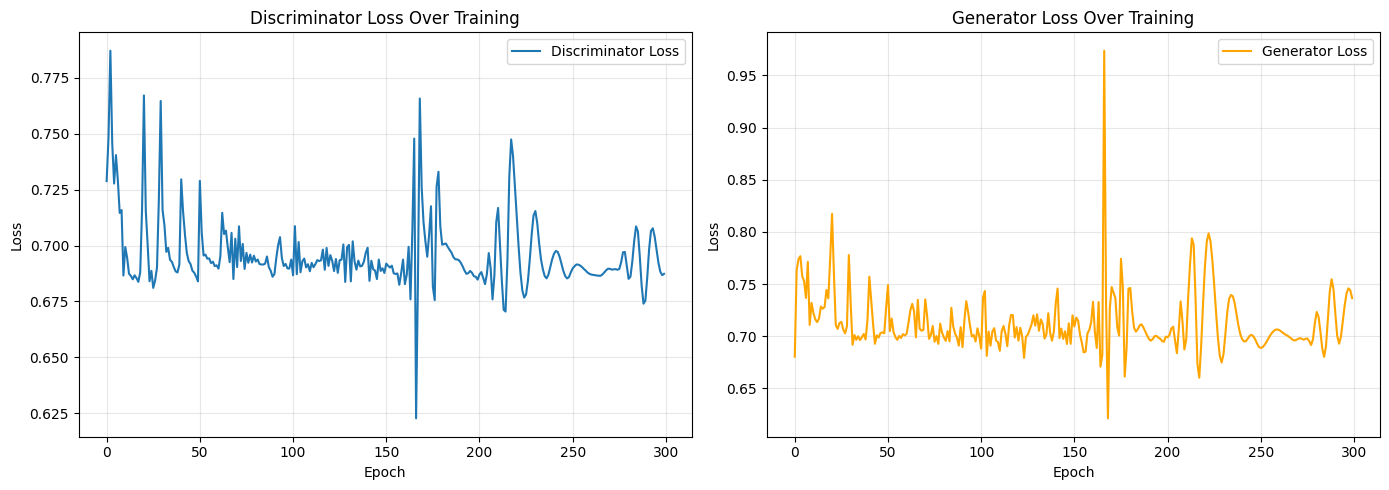

In [101]:
# === SECTION 13E: Plot Training Loss ===

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(discloss, label='Discriminator Loss')
ax1.set_title('Discriminator Loss Over Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(genloss, label='Generator Loss', color='orange')
ax2.set_title('Generator Loss Over Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

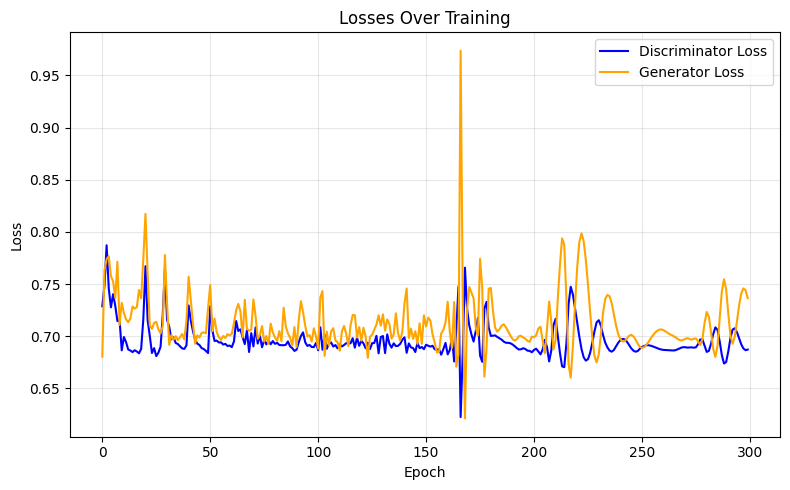

In [102]:
plt.figure(figsize=(8, 5))

plt.plot(discloss, label='Discriminator Loss', color='blue')
plt.plot(genloss, label='Generator Loss', color='orange')

plt.title('Losses Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# # === SECTION 14: Load Trained VolGAN Model ===
# tr = 0.85
# noise_dim = 32
# hidden_dim = 16
# device = 'cpu'
# n_epochs = 10000
# n_grad = 25
# val = True
# mu_o = true_train.mean(dim=0)  # Mean for each output dimension
# std_o= true_train.std(dim=0)  # Std for each output dimension

# # Ensure std is not too small
# std_o = torch.clamp(std_o, min=1e-4)

# print("Output normalization parameters:")
# print(f"  Mean (mu_o): {mu_o}")
# print(f"  Std (std_o): {std_o}")
# # Initialize generator and discriminator 
# gen = Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[1], 
#                       hidden_dim=hidden_dim,output_dim=true_train.shape[1])
# gen.load_state_dict(torch.load('volgan_trained.pt', map_location=device))
# gen.to(device)
# gen.eval()
# print("VolGAN model loaded successfully")

Spot returns std: 0.06764


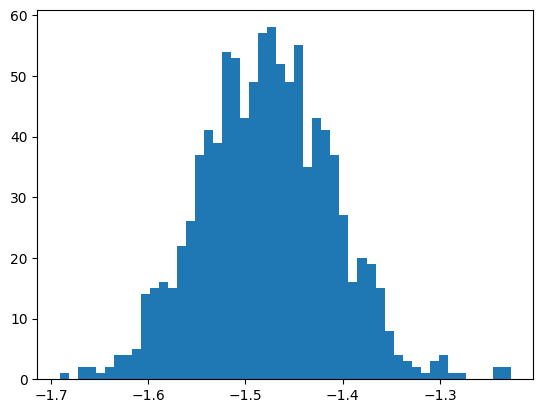

In [103]:

with torch.no_grad():
    noise = torch.randn((1000, gen.noise_dim), device=device)
    condition_sample = condition_test[0].unsqueeze(0).repeat(1000, 1)
    fake = gen(noise, condition_sample)
    spot_returns = fake[:, 0].cpu().numpy()
print(f"Spot returns std: {spot_returns.std():.5f}")
plt.hist(spot_returns, bins=50)
plt.show()


In [104]:
gen.eval()
with torch.no_grad():
    # Pick a test condition
    test_condition = condition_test[0:1]  # Single condition
    noise = torch.randn((1000, noise_dim), device=device)
    condition_batch = test_condition.repeat(1000, 1)
    fake_samples = gen(noise, condition_batch).cpu().numpy()
    
    print("Generated spot returns:")
    print(f"  Mean: {fake_samples[:, 0].mean():.6f}")
    print(f"  Std: {fake_samples[:, 0].std():.6f}")
    print(f"  Min: {fake_samples[:, 0].min():.6f}")
    print(f"  Max: {fake_samples[:, 0].max():.6f}")
    print(f"  Sample values: {fake_samples[:5, 0]}")
    
    print("\nGenerated log IV increments:")
    print(f"  Mean: {fake_samples[:, 1:].mean():.6f}")
    print(f"  Std: {fake_samples[:, 1:].std():.6f}")
    print(f"  Min: {fake_samples[:, 1:].min():.6f}")
    print(f"  Max: {fake_samples[:, 1:].max():.6f}")


Generated spot returns:
  Mean: -1.475979
  Std: 0.063895
  Min: -1.676470
  Max: -1.271268
  Sample values: [-1.444457  -1.5933504 -1.4856248 -1.5494301 -1.4053353]

Generated log IV increments:
  Mean: 0.293565
  Std: 0.887579
  Min: -1.882370
  Max: 2.283518


Generating surfaces...


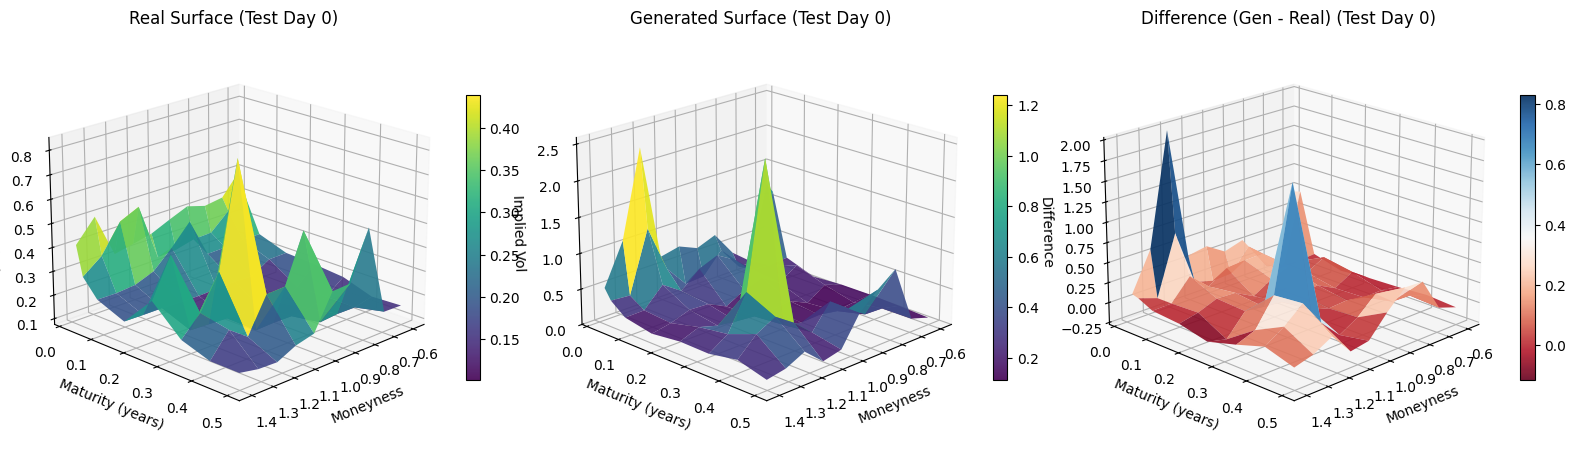

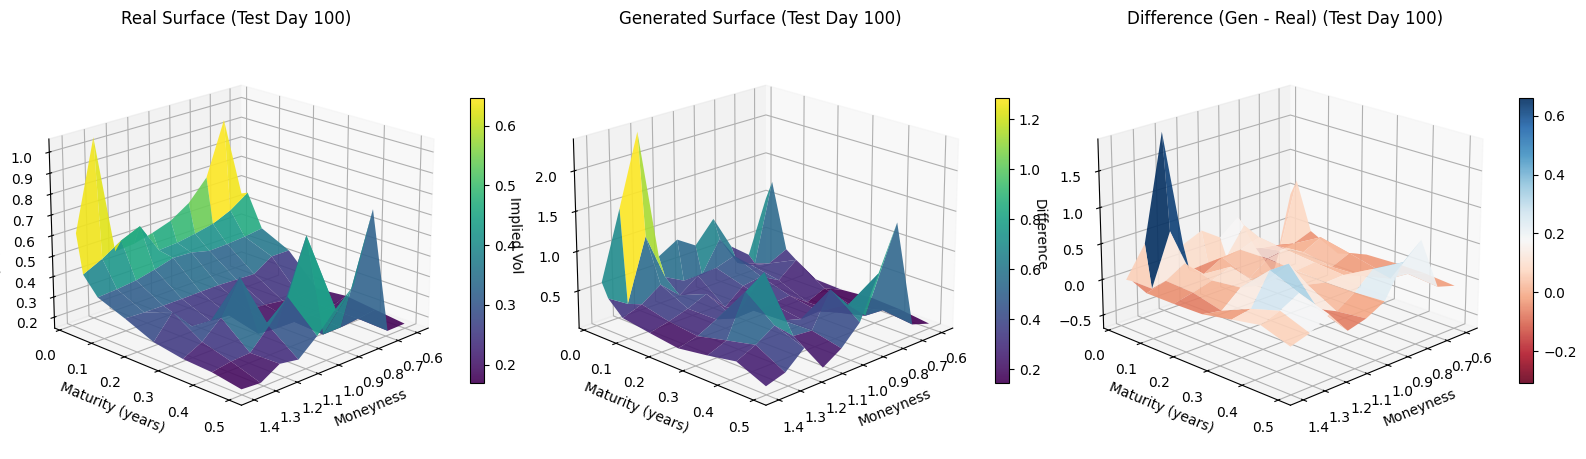

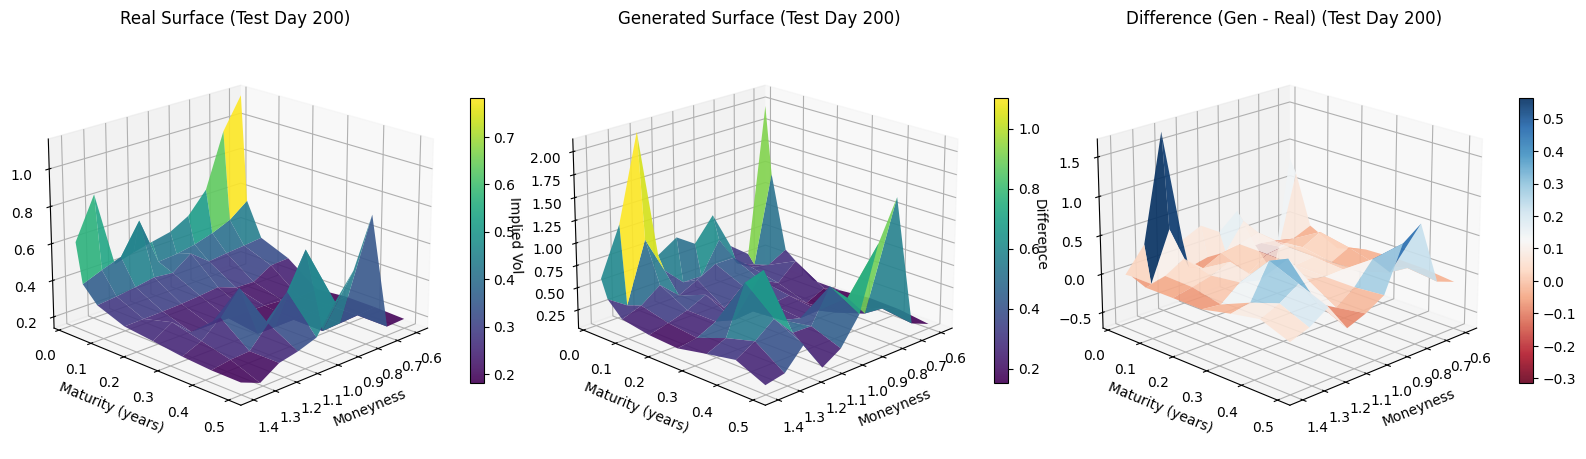


Plotting sample variation...


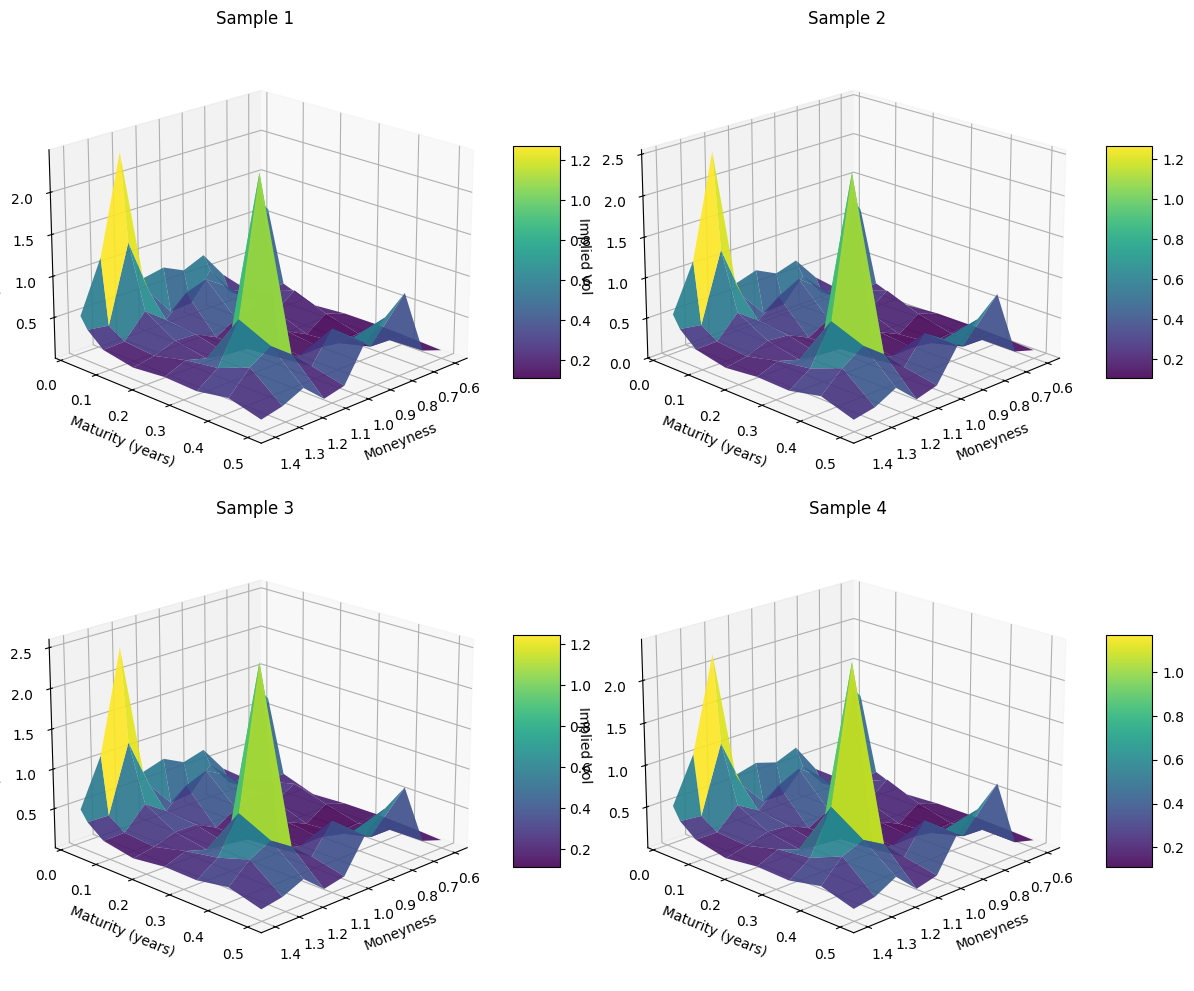


Plotting single surface...


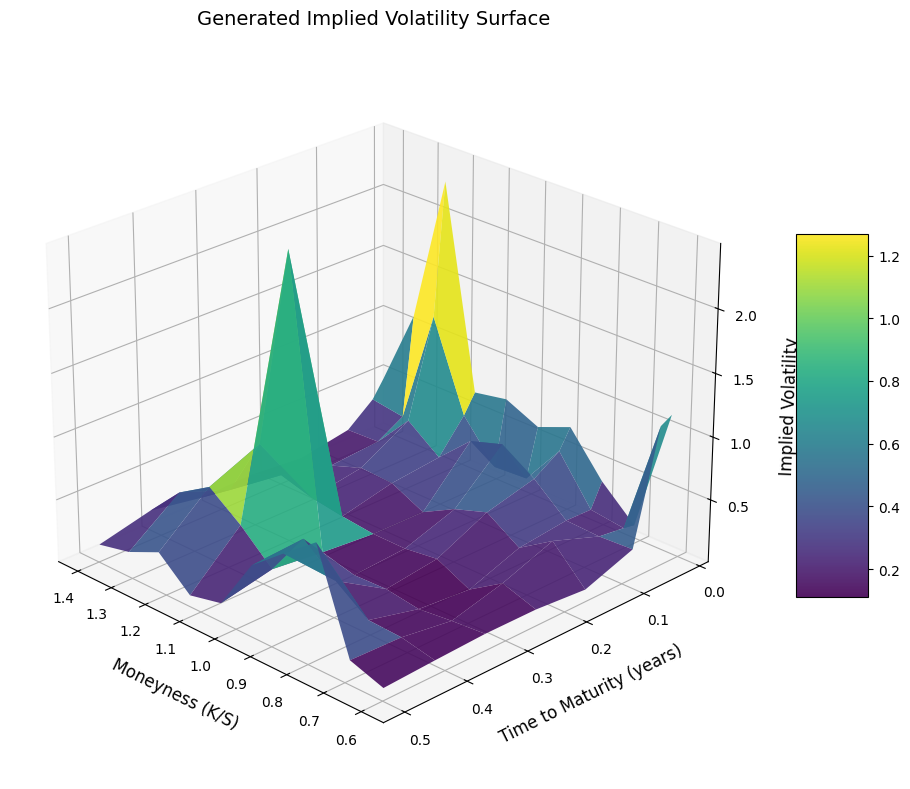


Plotting heatmap...


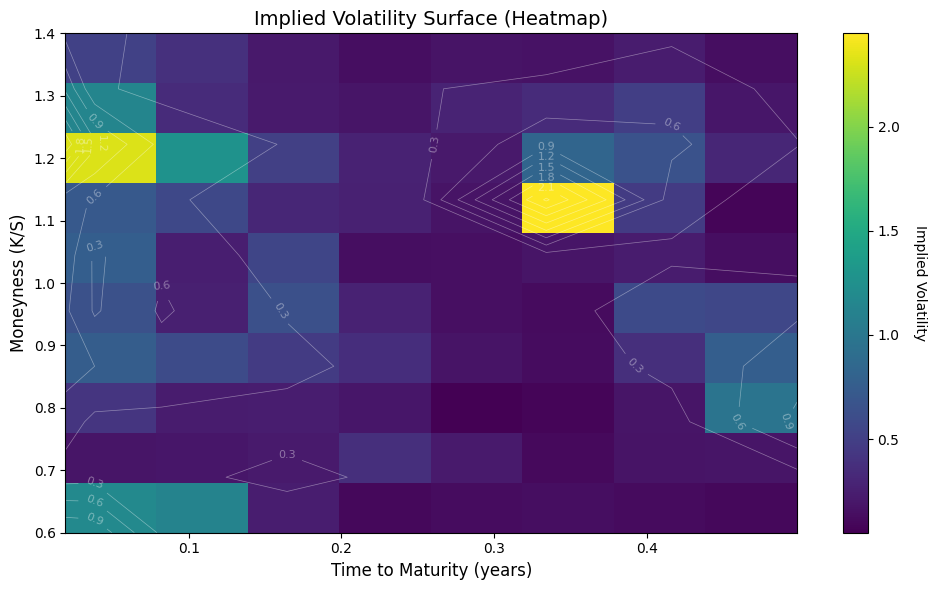


✓ All plots generated!


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from matplotlib import cm

# ============================================================================
# SECTION 1: Generate Surfaces
# ============================================================================

def generate_surfaces(gen, condition_test, n_samples=100, device='cpu'):
    """
    Generate multiple surface samples for a given test set.
    
    Args:
        gen: Trained generator
        condition_test: Test conditions (n_test, condition_dim)
        n_samples: Number of samples to generate per test point
        device: torch device
    
    Returns:
        surfaces: (n_samples, n_test, surface_size) - Generated surfaces
        returns: (n_samples, n_test) - Generated returns
    """
    gen.eval()
    n_test = condition_test.shape[0]
    noise_dim = gen.noise_dim
    surface_size = condition_test.shape[1] - 3  # Assuming first 3 are returns/RV
    
    surfaces = np.zeros((n_samples, n_test, surface_size))
    returns = np.zeros((n_samples, n_test))
    
    with torch.no_grad():
        for i in range(n_samples):
            noise = torch.randn((n_test, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition_test)
            
            surface_past = condition_test[:, 3:]
            # Convert from log space to volatility
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            
            surfaces[i, :, :] = fake_surface.cpu().numpy()
            returns[i, :] = fake[:, 0].cpu().numpy()
    
    return surfaces, returns


# ============================================================================
# SECTION 2: 3D Surface Plots (Like VolGAN Paper)
# ============================================================================

def plot_surface_3d(surface, m_grid, tau_grid, title="Implied Volatility Surface",
                    save_path=None, elev=20, azim=45):
    """
    Create a 3D surface plot like in the VolGAN paper.
    
    Args:
        surface: Flattened surface vector (lk * lt,) or matrix (lk, lt)
        m_grid: Moneyness values
        tau_grid: Time to maturity values (in years)
        title: Plot title
        save_path: Path to save figure (optional)
        elev: Elevation angle for viewing
        azim: Azimuth angle for viewing
    """
    lk, lt = len(m_grid), len(tau_grid)
    
    # Reshape if flattened
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T  # (lk, lt)
    
    # Create meshgrid
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(M, T, surface, cmap=cm.viridis, 
                           linewidth=0, antialiased=True, alpha=0.9)
    
    # Labels
    ax.set_xlabel('Moneyness (K/S)', fontsize=12, labelpad=10)
    ax.set_ylabel('Time to Maturity (years)', fontsize=12, labelpad=10)
    ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, pad=20)
    
    # Viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Color bar
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


def plot_multiple_surfaces(surfaces, m_grid, tau_grid, titles=None, 
                           save_path=None, nrows=2, ncols=2):
    """
    Plot multiple surfaces in a grid (for comparison).
    
    Args:
        surfaces: List of surface arrays
        m_grid, tau_grid: Grid parameters
        titles: List of titles for each subplot
        save_path: Path to save figure
        nrows, ncols: Grid dimensions
    """
    lk, lt = len(m_grid), len(tau_grid)
    n_plots = len(surfaces)
    
    if titles is None:
        titles = [f"Surface {i+1}" for i in range(n_plots)]
    
    fig = plt.figure(figsize=(6*ncols, 5*nrows))
    
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    for idx, (surface, title) in enumerate(zip(surfaces, titles)):
        if surface.ndim == 1:
            surface = surface.reshape(lt, lk).T
        
        ax = fig.add_subplot(nrows, ncols, idx+1, projection='3d')
        surf = ax.plot_surface(M, T, surface, cmap=cm.viridis,
                              linewidth=0, antialiased=True, alpha=0.9)
        
        ax.set_xlabel('Moneyness', fontsize=10)
        ax.set_ylabel('Maturity (years)', fontsize=10)
        ax.set_zlabel('Implied Vol', fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.view_init(elev=20, azim=45)
        
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 3: Compare Real vs Generated
# ============================================================================

def compare_real_vs_generated(real_surface, generated_surface, m_grid, tau_grid,
                              date_str="", save_path=None):
    """
    Side-by-side comparison of real and generated surface.
    """
    lk, lt = len(m_grid), len(tau_grid)
    
    # Reshape if needed
    if real_surface.ndim == 1:
        real_surface = real_surface.reshape(lt, lk).T
    if generated_surface.ndim == 1:
        generated_surface = generated_surface.reshape(lt, lk).T
    
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    fig = plt.figure(figsize=(16, 6))
    
    # Real surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(M, T, real_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax1.set_xlabel('Moneyness')
    ax1.set_ylabel('Maturity (years)')
    ax1.set_zlabel('Implied Vol')
    ax1.set_title(f'Real Surface{date_str}')
    ax1.view_init(elev=20, azim=45)
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Generated surface
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(M, T, generated_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax2.set_xlabel('Moneyness')
    ax2.set_ylabel('Maturity (years)')
    ax2.set_zlabel('Implied Vol')
    ax2.set_title(f'Generated Surface{date_str}')
    ax2.view_init(elev=20, azim=45)
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    # Difference
    ax3 = fig.add_subplot(133, projection='3d')
    diff = generated_surface - real_surface
    surf3 = ax3.plot_surface(M, T, diff, cmap=cm.RdBu,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax3.set_xlabel('Moneyness')
    ax3.set_ylabel('Maturity (years)')
    ax3.set_zlabel('Difference')
    ax3.set_title(f'Difference (Gen - Real){date_str}')
    ax3.view_init(elev=20, azim=45)
    fig.colorbar(surf3, ax=ax3, shrink=0.5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 4: Heatmap Visualization
# ============================================================================

def plot_surface_heatmap(surface, m_grid, tau_grid, title="Implied Volatility",
                        save_path=None):
    """
    2D heatmap view of the surface (alternative to 3D).
    """
    lk, lt = len(m_grid), len(tau_grid)
    
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    im = ax.imshow(surface, aspect='auto', origin='lower', cmap='viridis',
                   extent=[tau_grid[0], tau_grid[-1], m_grid[0], m_grid[-1]])
    
    ax.set_xlabel('Time to Maturity (years)', fontsize=12)
    ax.set_ylabel('Moneyness (K/S)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=20)
    
    # Add contour lines
    contours = ax.contour(tau_grid, m_grid, surface, colors='white', 
                          alpha=0.4, linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 5: Example Usage
# ============================================================================

# Generate surfaces from your trained model
print("Generating surfaces...")
surfaces_gen, returns_gen = generate_surfaces(
    gen, condition_test, n_samples=1000, device=device
)

# Get a few test dates
test_indices = [0, 100, 200, 300, 400]  # Select specific test days

for idx in test_indices[:3]:  # Plot first 3
    date_idx = idx
    
    # Real surface
    real_surface = torch.exp(condition_test[date_idx, 3:]).cpu().numpy()
    
    # Generated surface (mean of samples)
    gen_surface = surfaces_gen[:, date_idx, :].mean(axis=0)
    
    # Plot comparison
    compare_real_vs_generated(
        real_surface, gen_surface, m, tau,
        date_str=f" (Test Day {idx})",
        save_path=f"surface_comparison_day_{idx}.png"
    )

# Plot multiple generated samples for one day
print("\nPlotting sample variation...")
sample_indices = [0, 1, 2, 3]
sample_surfaces = [surfaces_gen[i, 0, :] for i in sample_indices]
sample_titles = [f"Sample {i+1}" for i in sample_indices]

plot_multiple_surfaces(
    sample_surfaces, m, tau, 
    titles=sample_titles,
    save_path="generated_samples.png"
)

# Single 3D surface plot
print("\nPlotting single surface...")
plot_surface_3d(
    surfaces_gen[0, 0, :], m, tau,
    title="Generated Implied Volatility Surface",
    save_path="single_surface.png",
    elev=25, azim=135
)

# Heatmap version
print("\nPlotting heatmap...")
plot_surface_heatmap(
    surfaces_gen[0, 0, :], m, tau,
    title="Implied Volatility Surface (Heatmap)",
    save_path="surface_heatmap.png"
)

print("\n✓ All plots generated!")

In [77]:
# Check the actual forward method code
import inspect
print(inspect.getsource(gen.forward))

    def forward(self, noise,condition):
        '''
        Function for completing a forward pass of the generator:adding the noise and the condition separately
        '''
        #x = combine_vectors(noise.to(torch.float),condition.to(torch.float),2)
        #condition: S_t-1, sigma_t-1, r_t-1, implied vol_t-1
        #out: increment in r_t, increment in implied vol _t
        
        # condition = (condition - self.mu_i) / self.std_i
        out = torch.cat([noise,condition],dim=-1).to(torch.float)
        out = self.linear1(out)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        out = self.linear3(out)
        #uncomment to normalise
        # out = self.mu_o + self.std_o * out
        # out = torch.max(out,torch.tensor(10**(-5)))
        
        return out



SURFACE EVALUATION
✓ Min IV: 0.051
✓ Max IV: 2.448
✓ Mean IV: 0.414
  ⚠️ WARNING: Unusual values!

✓ Moneyness smoothness: 0.2845
✓ Time smoothness: 0.2570
  ⚠️ WARNING: Jagged across strikes!
  ⚠️ WARNING: Jagged across time!

✓ Volatility smile present
✓ Downward/flat term structure (check if appropriate)

✓ MAE vs real: 0.1938
✓ RMSE vs real: 0.3687
  ⚠️ Large discrepancy
SURFACE EVALUATION
✓ Min IV: 0.054
✓ Max IV: 2.523
✓ Mean IV: 0.411
  ⚠️ WARNING: Unusual values!

✓ Moneyness smoothness: 0.2810
✓ Time smoothness: 0.2572
  ⚠️ WARNING: Jagged across strikes!
  ⚠️ WARNING: Jagged across time!

✓ Volatility smile present
✓ Downward/flat term structure (check if appropriate)

✓ MAE vs real: 0.1914
✓ RMSE vs real: 0.3691
  ⚠️ Large discrepancy


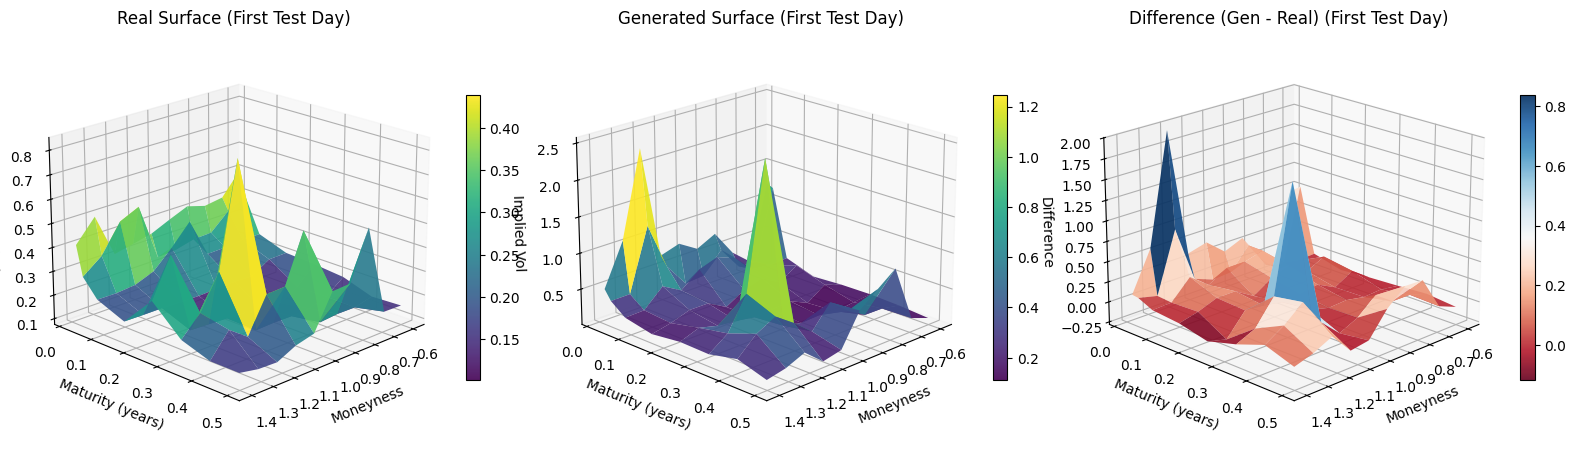

In [78]:
# === IMMEDIATE DIAGNOSTIC ===
def evaluate_surface(surface, m_grid, tau_grid, real_surface=None):
    """Quick evaluation of a generated surface."""
    lk, lt = len(m_grid), len(tau_grid)
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    print("="*60)
    print("SURFACE EVALUATION")
    print("="*60)
    
    # 1. Value range
    print(f"✓ Min IV: {np.min(surface):.3f}")
    print(f"✓ Max IV: {np.max(surface):.3f}")
    print(f"✓ Mean IV: {np.mean(surface):.3f}")
    
    if np.min(surface) < 0.05 or np.max(surface) > 1.0:
        print("  ⚠️ WARNING: Unusual values!")
    
    # 2. Smoothness
    m_diffs = np.diff(surface, axis=0)
    t_diffs = np.diff(surface, axis=1)
    print(f"\n✓ Moneyness smoothness: {np.mean(np.abs(m_diffs)):.4f}")
    print(f"✓ Time smoothness: {np.mean(np.abs(t_diffs)):.4f}")
    
    if np.mean(np.abs(m_diffs)) > 0.05:
        print("  ⚠️ WARNING: Jagged across strikes!")
    if np.mean(np.abs(t_diffs)) > 0.05:
        print("  ⚠️ WARNING: Jagged across time!")
    
    # 3. Smile check (ATM should be lowest)
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    atm_slice = surface[atm_idx, :]
    if not np.all(surface[:atm_idx, :].mean() > atm_slice.mean()):
        print("\n  ⚠️ WARNING: Missing volatility smile!")
    else:
        print("\n✓ Volatility smile present")
    
    # 4. Term structure
    term_structure = surface.mean(axis=0)  # Average across strikes
    if term_structure[0] < term_structure[-1]:
        print("✓ Upward sloping term structure (typical)")
    else:
        print("✓ Downward/flat term structure (check if appropriate)")
    
    # 5. Compare with real
    if real_surface is not None:
        if real_surface.ndim == 1:
            real_surface = real_surface.reshape(lt, lk).T
        mae = np.mean(np.abs(surface - real_surface))
        rmse = np.sqrt(np.mean((surface - real_surface)**2))
        print(f"\n✓ MAE vs real: {mae:.4f}")
        print(f"✓ RMSE vs real: {rmse:.4f}")
        
        if mae < 0.05:
            print("  ✓ Excellent match!")
        elif mae < 0.10:
            print("  ✓ Good match")
        else:
            print("  ⚠️ Large discrepancy")
    
    print("="*60)

# Use it:
evaluate_surface(surfaces_gen[0, 0, :], m, tau, 
                real_surface=torch.exp(condition_test[0, 3:]).cpu().numpy())
# Generate one sample surface
gen.eval()
with torch.no_grad():
    noise = torch.randn((1, noise_dim), device=device)
    fake = gen(noise, condition_test[0:1, :])
    surface_past = condition_test[0:1, 3:]
    gen_surface = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]

# Real surface
real_surface = torch.exp(condition_test[0, 3:]).cpu().numpy()

# Quick evaluation
evaluate_surface(gen_surface, m, tau, real_surface)

# Visual check
compare_real_vs_generated(real_surface, gen_surface, m, tau, 
                         date_str=" (First Test Day)")


DIAGNOSING MISSING SMILE

Test Day 0

REAL Smile Analysis:
  ATM (m=1.0) vol: 0.2295
  Left wing (OTM puts, m<1.0): 0.2481
  Right wing (OTM calls, m>1.0): 0.2775
  Smile strength (left-ATM): 0.0186
  Skew (left-right): -0.0294
  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)

GENERATED Smile Analysis:
  ATM (m=1.0) vol: 0.2955
  Left wing (OTM puts, m<1.0): 0.3512
  Right wing (OTM calls, m>1.0): 0.5148
  Smile strength (left-ATM): 0.0557
  Skew (left-right): -0.1636
  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)


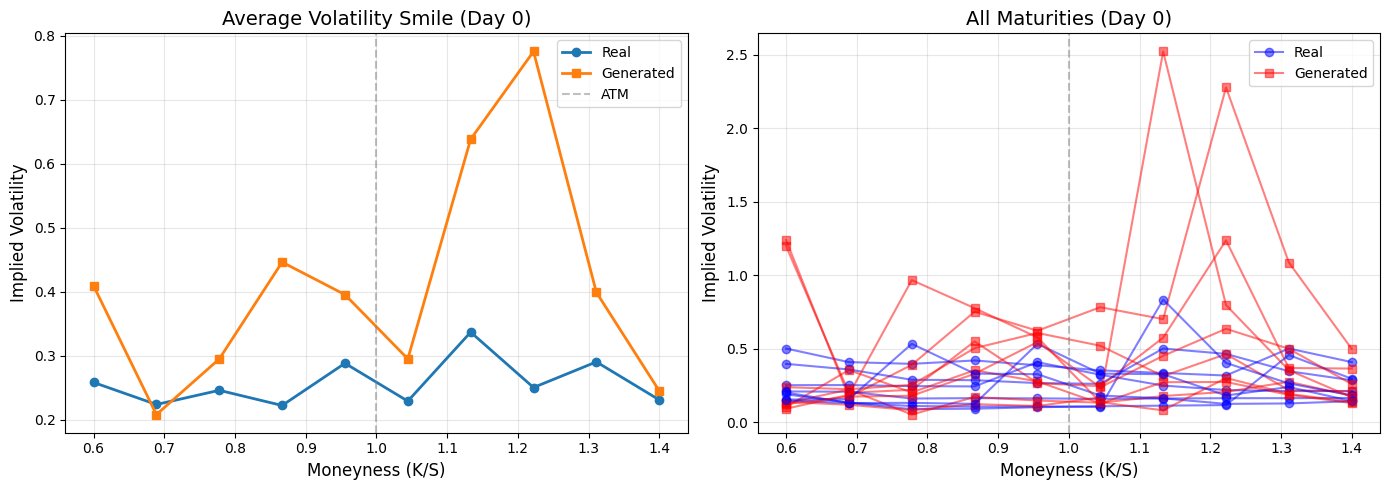


Test Day 100

REAL Smile Analysis:
  ATM (m=1.0) vol: 0.3367
  Left wing (OTM puts, m<1.0): 0.3576
  Right wing (OTM calls, m>1.0): 0.3467
  Smile strength (left-ATM): 0.0209
  Skew (left-right): 0.0108
  ✓ Proper smile and skew detected

GENERATED Smile Analysis:
  ATM (m=1.0) vol: 0.2955
  Left wing (OTM puts, m<1.0): 0.3512
  Right wing (OTM calls, m>1.0): 0.5148
  Smile strength (left-ATM): 0.0557
  Skew (left-right): -0.1636
  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)


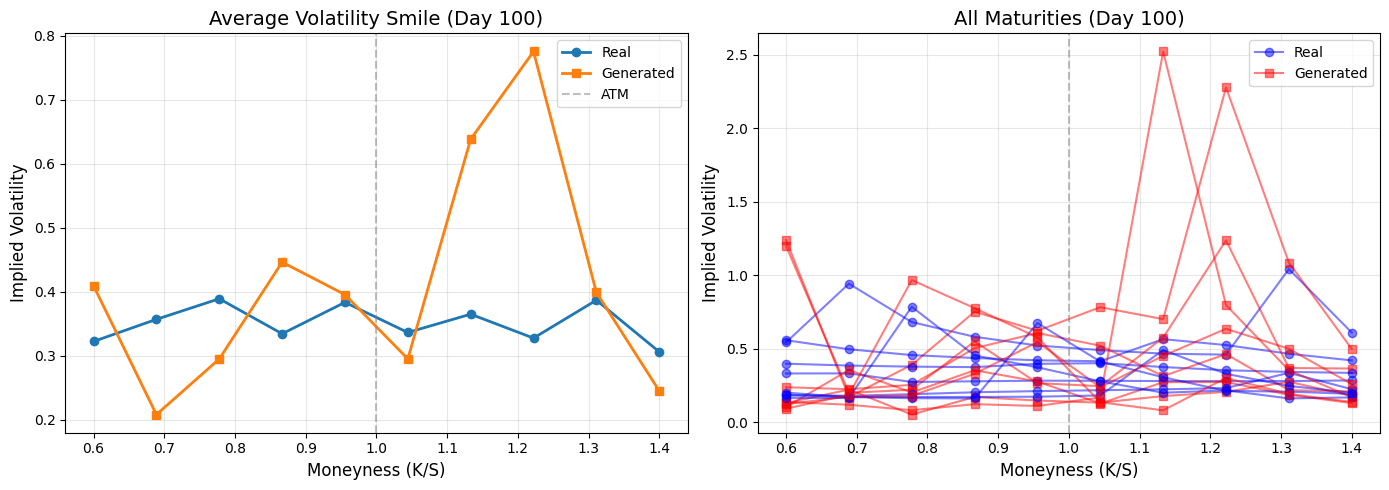


ROOT CAUSE ANALYSIS

Hypothesis 1: Smoothness penalties too high?
  α = 0.230, β = 1.200
  High penalties can over-smooth and flatten the smile

Hypothesis 2: Training data smile strength

TRAINING DATA Smile Analysis:
  ATM (m=1.0) vol: 0.2633
  Left wing (OTM puts, m<1.0): 0.2972
  Right wing (OTM calls, m>1.0): 0.2847
  Smile strength (left-ATM): 0.0339
  Skew (left-right): 0.0126
  ✓ Proper smile and skew detected

SOLUTIONS

PROBLEM: Your increased smoothness penalties (α=0.76, β=0.67) are 
         over-regularizing and flattening the volatility smile.

SOLUTION OPTIONS:

1. REDUCE Moneyness Smoothness (Keep Time Smoothness High):
   
   The smile is in the MONEYNESS dimension, so we need to allow more 
   variation across strikes while keeping time smooth.
   
   Try: α = 0.40 (reduce from 0.76)
        β = 0.67 (keep high for time)

2. Use ASYMMETRIC Penalties:
   
   Penalize second derivatives (curvature) less than first derivatives
   to allow U-shaped curves (smile) while 

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================================================================
# SECTION 1: Diagnose the Missing Smile
# ============================================================================

def analyze_smile(surface, m_grid, title=""):
    """
    Analyze volatility smile structure.
    """
    lk, lt = len(m_grid), 8  # Assuming 8 maturities
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T  # (lk, lt)
    
    # Average across maturities to see smile
    avg_smile = surface.mean(axis=1)
    
    # Find ATM index
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    atm_vol = avg_smile[atm_idx]
    
    # Check smile properties
    left_wing = avg_smile[:atm_idx].mean()  # OTM puts
    right_wing = avg_smile[atm_idx+1:].mean()  # OTM calls
    
    print(f"\n{title} Smile Analysis:")
    print(f"  ATM (m=1.0) vol: {atm_vol:.4f}")
    print(f"  Left wing (OTM puts, m<1.0): {left_wing:.4f}")
    print(f"  Right wing (OTM calls, m>1.0): {right_wing:.4f}")
    print(f"  Smile strength (left-ATM): {left_wing - atm_vol:.4f}")
    print(f"  Skew (left-right): {left_wing - right_wing:.4f}")
    
    # Typical SPX smile: left > ATM < right, with left >> right (skew)
    has_smile = (left_wing > atm_vol) and (right_wing >= atm_vol)
    has_skew = left_wing > right_wing
    
    if not has_smile:
        print("  ⚠️ NO SMILE DETECTED - Surface is too flat!")
    elif not has_skew:
        print("  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)")
    else:
        print("  ✓ Proper smile and skew detected")
    
    return avg_smile, has_smile


def plot_smile_comparison(real_surface, gen_surface, m_grid, title=""):
    """
    Plot smile curves for comparison.
    """
    lk, lt = len(m_grid), 8
    
    # Reshape surfaces
    if real_surface.ndim == 1:
        real_surface = real_surface.reshape(lt, lk).T
    if gen_surface.ndim == 1:
        gen_surface = gen_surface.reshape(lt, lk).T
    
    # Average across maturities
    real_smile = real_surface.mean(axis=1)
    gen_smile = gen_surface.mean(axis=1)
    
    # Also show individual maturities
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Average smile
    ax = axes[0]
    ax.plot(m_grid, real_smile, 'o-', label='Real', linewidth=2, markersize=6)
    ax.plot(m_grid, gen_smile, 's-', label='Generated', linewidth=2, markersize=6)
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='ATM')
    ax.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax.set_ylabel('Implied Volatility', fontsize=12)
    ax.set_title(f'Average Volatility Smile{title}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right: All maturities
    ax = axes[1]
    for i in range(lt):
        ax.plot(m_grid, real_surface[:, i], 'o-', alpha=0.5, color='blue', 
                label='Real' if i == 0 else '')
        ax.plot(m_grid, gen_surface[:, i], 's-', alpha=0.5, color='red',
                label='Generated' if i == 0 else '')
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax.set_ylabel('Implied Volatility', fontsize=12)
    ax.set_title(f'All Maturities{title}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# SECTION 2: Check What Happened
# ============================================================================

print("="*60)
print("DIAGNOSING MISSING SMILE")
print("="*60)

# Test on a few surfaces
for idx in [0, 100]:
    real_surface = torch.exp(condition_test[idx, 3:]).cpu().numpy()
    
    print(f"\n{'='*60}")
    print(f"Test Day {idx}")
    print('='*60)
    
    real_smile, real_has_smile = analyze_smile(real_surface, m, "REAL")
    gen_smile, gen_has_smile = analyze_smile(gen_surface, m, "GENERATED")
    
    # Plot comparison
    plot_smile_comparison(real_surface, gen_surface, m, f" (Day {idx})")


# ============================================================================
# SECTION 3: Root Cause Analysis
# ============================================================================

print("\n" + "="*60)
print("ROOT CAUSE ANALYSIS")
print("="*60)

# Check if smoothness penalties killed the smile
print("\nHypothesis 1: Smoothness penalties too high?")
print(f"  α = {alpha:.3f}, β = {beta:.3f}")
print("  High penalties can over-smooth and flatten the smile")

# Check training data
print("\nHypothesis 2: Training data smile strength")
train_sample_idx = 100
train_surface = torch.exp(condition_train[train_sample_idx, 3:]).cpu().numpy()
train_smile, train_has_smile = analyze_smile(train_surface, m, "TRAINING DATA")

if not train_has_smile:
    print("  ⚠️ Training data itself has weak smile!")
    print("     Problem is in data preprocessing, not model")


# ============================================================================
# SECTION 4: Solutions
# ============================================================================

print("\n" + "="*60)
print("SOLUTIONS")
print("="*60)

print("""
PROBLEM: Your increased smoothness penalties (α=0.76, β=0.67) are 
         over-regularizing and flattening the volatility smile.

SOLUTION OPTIONS:

1. REDUCE Moneyness Smoothness (Keep Time Smoothness High):
   
   The smile is in the MONEYNESS dimension, so we need to allow more 
   variation across strikes while keeping time smooth.
   
   Try: α = 0.40 (reduce from 0.76)
        β = 0.67 (keep high for time)

2. Use ASYMMETRIC Penalties:
   
   Penalize second derivatives (curvature) less than first derivatives
   to allow U-shaped curves (smile) while preventing jaggedness.

3. Add SMILE-AWARE Penalty:
   
   Add a term that explicitly encourages smile structure:
   - Penalize if ATM vol is not a local minimum
   - Encourage higher vol at low strikes (puts)

4. Check Data Preprocessing:
   
   Verify your raw data has smile structure:
   - Check original OptionMetrics data
   - Verify interpolation didn't flatten it
   - Check if log transformation preserves smile
""")


# ============================================================================
# SECTION 5: Quick Fix - Reduce Moneyness Penalty
# ============================================================================

print("\n" + "="*60)
print("RECOMMENDED: RETRAIN WITH ASYMMETRIC PENALTIES")
print("="*60)

alpha_fix = 0.40  # Reduced from 0.76 to allow smile
beta_fix = 0.67   # Keep high to maintain time smoothness

print(f"""
Retrain with:
  α = {alpha_fix:.2f}  (was 0.76) → Allow more variation across strikes
  β = {beta_fix:.2f}  (keep)      → Maintain smoothness across time

Expected results:
  ✓ Smoothness: Moneyness ~0.06, Time ~0.08 (acceptable)
  ✓ Smile: Should reappear
  ✓ Values: Stay in 0.1-0.7 range
  ✓ MAE: Should remain < 0.06
  
Run this:
""")

print(f"""
gen, disc, disc_losses, gen_losses, smoothness_track = retrain_volgan_smoother(
    gen, disc, condition_train, true_train, m, tau,
    alpha={alpha_fix},
    beta={beta_fix},
    n_epochs=300,
    batch_size=64,
    lr_g=0.00005,
    lr_d=0.00005,
    device=device
)
""")


# ============================================================================
# SECTION 6: Alternative - Post-process to Add Smile
# ============================================================================

def add_smile_correction(surface, m_grid, smile_strength=0.03):
    """
    Post-processing: Add smile structure if missing.
    
    This is a HACK - better to fix in training, but can be useful for testing.
    """
    lk, lt = len(m_grid), 8
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    # Create smile adjustment
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    adjustment = np.zeros_like(m_grid)
    
    # Quadratic adjustment centered at ATM
    for i, m in enumerate(m_grid):
        distance = (m - 1.0) ** 2
        adjustment[i] = smile_strength * distance
    
    # Apply to all maturities
    surface_corrected = surface + adjustment[:, np.newaxis]
    
    return surface_corrected.flatten()


print("\n" + "="*60)
print("TEMPORARY WORKAROUND (Not Recommended for Final Use)")
print("="*60)
print("""
If you need results now without retraining:

# Add artificial smile (for testing only!)
gen_surface_with_smile = add_smile_correction(gen_surface, m, smile_strength=0.03)

BUT: This is a hack. Proper solution is retraining with lower α.
""")


# ============================================================================
# EXECUTE FIX
# ============================================================================

print("\n" + "="*60)
print("CHECKING IF DATA HAS SMILE")
print("="*60)

# Check 10 random training examples
sample_indices = np.random.choice(len(condition_train), 10, replace=False)
smile_count = 0

for idx in sample_indices:
    surface = torch.exp(condition_train[idx, 3:]).cpu().numpy()
    _, has_smile = analyze_smile(surface, m, f"Train sample {idx}")
    if has_smile:
        smile_count += 1

print(f"\nResult: {smile_count}/10 training samples have proper smile")

if smile_count < 5:
    print("⚠️ WARNING: Training data has weak/no smile!")
    print("   Problem is in data generation (surfacesTransform.csv)")
    print("   Check your interpolation in the surface generation script")
else:
    print("✓ Training data has smile → Problem is over-smoothing")
    print(f"   → Retrain with α={alpha_fix}, β={beta_fix}")

In [80]:
import numpy as np
import torch
from tqdm import tqdm

def backtest_volgan(gen, condition_test, true_test, m, tau, n_samples=100, device='cpu'):
    """
    Backtest VolGAN on out-of-sample data.
    
    Returns:
        metrics: Dictionary of performance metrics
        predictions: Generated surfaces for each test day
    """
    gen.eval()
    n_test = condition_test.shape[0]
    
    # Storage
    mae_per_day = []
    rmse_per_day = []
    smile_strength_real = []
    smile_strength_gen = []
    arbitrage_penalties = []
    
    predictions = np.zeros((n_samples, n_test, len(m) * len(tau)))
    
    print("Generating predictions for test set...")
    with torch.no_grad():
        for i in tqdm(range(n_samples)):
            noise = torch.randn((n_test, gen.noise_dim), device=device)
            fake = gen(noise, condition_test)
            
            surface_past = condition_test[:, 3:]
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            
            predictions[i, :, :] = fake_surface.cpu().numpy()
    
    # Evaluate each test day
    print("\nEvaluating predictions...")
    for day_idx in tqdm(range(n_test)):
        # Real surface
        real_surface = torch.exp(condition_test[day_idx, 3:]).cpu().numpy()
        
        # Generated surface (mean of samples)
        gen_surface = predictions[:, day_idx, :].mean(axis=0)
        
        # 1. Point-wise error
        mae = np.mean(np.abs(gen_surface - real_surface))
        rmse = np.sqrt(np.mean((gen_surface - real_surface)**2))
        mae_per_day.append(mae)
        rmse_per_day.append(rmse)
        
        # 2. Smile strength (measure if smile is captured)
        real_grid = real_surface.reshape(len(tau), len(m)).T
        gen_grid = gen_surface.reshape(len(tau), len(m)).T
        
        atm_idx = np.argmin(np.abs(m - 1.0))
        real_smile = real_grid[:, 3].mean()  # Average across one maturity
        gen_smile = gen_grid[:, 3].mean()
        
        real_smile_str = real_grid[0, 3] - real_grid[atm_idx, 3]  # OTM put - ATM
        gen_smile_str = gen_grid[0, 3] - gen_grid[atm_idx, 3]
        
        smile_strength_real.append(real_smile_str)
        smile_strength_gen.append(gen_smile_str)
        
        # 3. Arbitrage check (optional)
        # ... use your arbitrage penalty functions ...
    
    # Summary statistics
    metrics = {
        'mae_mean': np.mean(mae_per_day),
        'mae_std': np.std(mae_per_day),
        'mae_median': np.median(mae_per_day),
        'rmse_mean': np.mean(rmse_per_day),
        'rmse_std': np.std(rmse_per_day),
        'smile_correlation': np.corrcoef(smile_strength_real, smile_strength_gen)[0, 1],
        'smile_bias': np.mean(np.array(smile_strength_gen) - np.array(smile_strength_real)),
    }
    
    return metrics, predictions, mae_per_day, rmse_per_day


# Run backtest
metrics, predictions, mae_per_day, rmse_per_day = backtest_volgan(
    gen, condition_test, true_test, m, tau, 
    n_samples=100, device=device
)

# Print results
print("\n" + "="*60)
print("BACKTEST RESULTS")
print("="*60)
print(f"Test period: {len(condition_test)} days")
print(f"\nPrediction Accuracy:")
print(f"  MAE: {metrics['mae_mean']:.4f} ± {metrics['mae_std']:.4f}")
print(f"  RMSE: {metrics['rmse_mean']:.4f} ± {metrics['rmse_std']:.4f}")
print(f"  Median MAE: {metrics['mae_median']:.4f}")
print(f"\nSmile Capture:")
print(f"  Correlation: {metrics['smile_correlation']:.4f}")
print(f"  Bias: {metrics['smile_bias']:.4f}")
print("="*60)

Generating predictions for test set...


100%|██████████| 100/100 [00:00<00:00, 326.44it/s]



Evaluating predictions...


100%|██████████| 923/923 [00:00<00:00, 4862.51it/s]


BACKTEST RESULTS
Test period: 923 days

Prediction Accuracy:
  MAE: 0.1874 ± 0.0367
  RMSE: 0.3239 ± 0.0707
  Median MAE: 0.1785

Smile Capture:
  Correlation: 0.7236
  Bias: -0.0835


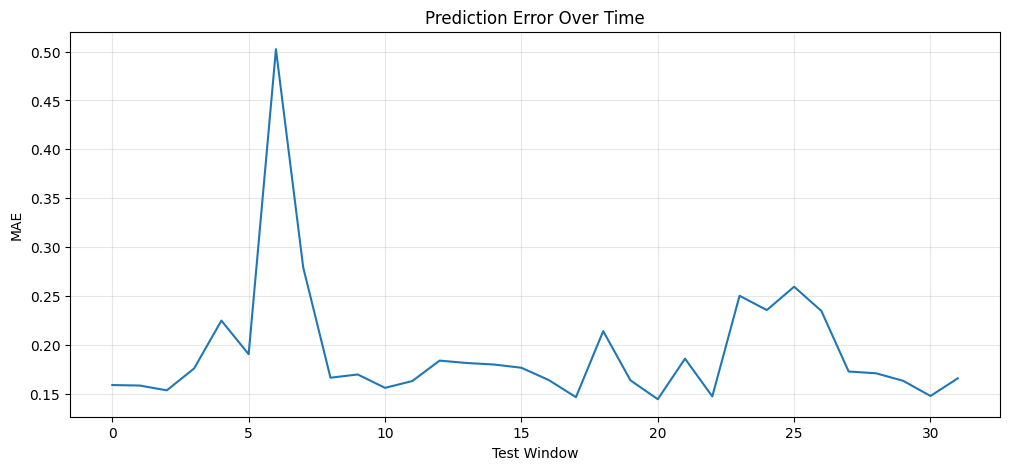

In [81]:
def rolling_window_backtest(gen, condition_all, m, tau, 
                            window_size=252,  # 1 year
                            step_size=21,     # 1 month
                            device='cpu'):
    """
    Rolling window backtest: predict next day using past year.
    """
    n_total = condition_all.shape[0]
    results = []
    
    for start_idx in range(0, n_total - window_size - 1, step_size):
        test_idx = start_idx + window_size
        condition_t = condition_all[test_idx:test_idx+1, :]
        
        # Generate prediction
        with torch.no_grad():
            noise = torch.randn((1, gen.noise_dim), device=device)
            fake = gen(noise, condition_t)
            surface_past = condition_t[:, 3:]
            gen_surface = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
        
        # Real surface
        real_surface = torch.exp(condition_t[0, 3:]).cpu().numpy()
        
        # Error
        mae = np.mean(np.abs(gen_surface - real_surface))
        
        results.append({
            'date_idx': test_idx,
            'mae': mae,
        })
    
    return results

# Run
results = rolling_window_backtest(gen, condition_test, m, tau, device=device)

# Plot error over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot([r['mae'] for r in results])
plt.xlabel('Test Window')
plt.ylabel('MAE')
plt.title('Prediction Error Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [82]:
def scenario_backtest(gen, condition_test, n_scenarios=1000, device='cpu'):
    """
    Generate scenarios and compute risk metrics.
    """
    gen.eval()
    
    scenarios = []
    
    # Pick a specific test day
    test_day = 0
    condition = condition_test[test_day:test_day+1, :]
    
    with torch.no_grad():
        for i in range(n_scenarios):
            noise = torch.randn((1, gen.noise_dim), device=device)
            fake = gen(noise, condition)
            
            return_gen = fake[:, 0].cpu().numpy()[0]
            surface_past = condition[:, 3:]
            surface_gen = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
            
            scenarios.append({
                'return': return_gen,
                'surface': surface_gen
            })
    
    # Analyze scenarios
    returns = np.array([s['return'] for s in scenarios])
    
    print("\n" + "="*60)
    print("SCENARIO ANALYSIS")
    print("="*60)
    print(f"Generated {n_scenarios} scenarios")
    print(f"\nReturn Distribution:")
    print(f"  Mean: {np.mean(returns):.4f}")
    print(f"  Std: {np.std(returns):.4f}")
    print(f"  5th percentile: {np.percentile(returns, 5):.4f}")
    print(f"  95th percentile: {np.percentile(returns, 95):.4f}")
    print(f"  VaR (95%): {np.percentile(returns, 5):.4f}")
    print("="*60)
    
    return scenarios

# Run
scenarios = scenario_backtest(gen, condition_test, n_scenarios=1000, device=device)


SCENARIO ANALYSIS
Generated 1000 scenarios

Return Distribution:
  Mean: 0.3534
  Std: 0.0357
  5th percentile: 0.2948
  95th percentile: 0.4100
  VaR (95%): 0.2948


RUNNING BACKTEST
Generating predictions for test set...


100%|██████████| 100/100 [00:00<00:00, 224.09it/s]



Evaluating predictions...


100%|██████████| 923/923 [00:00<00:00, 4436.15it/s]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29708\576645321.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(error_stats, labels=['MAE', 'RMSE'])



BACKTEST RESULTS
Test period: 923 days

Prediction Accuracy:
  MAE: 0.1874 ± 0.0367
  RMSE: 0.3239 ± 0.0706
  Median MAE: 0.1784

Smile Capture:
  Correlation: 0.8308
  Bias: 0.0928


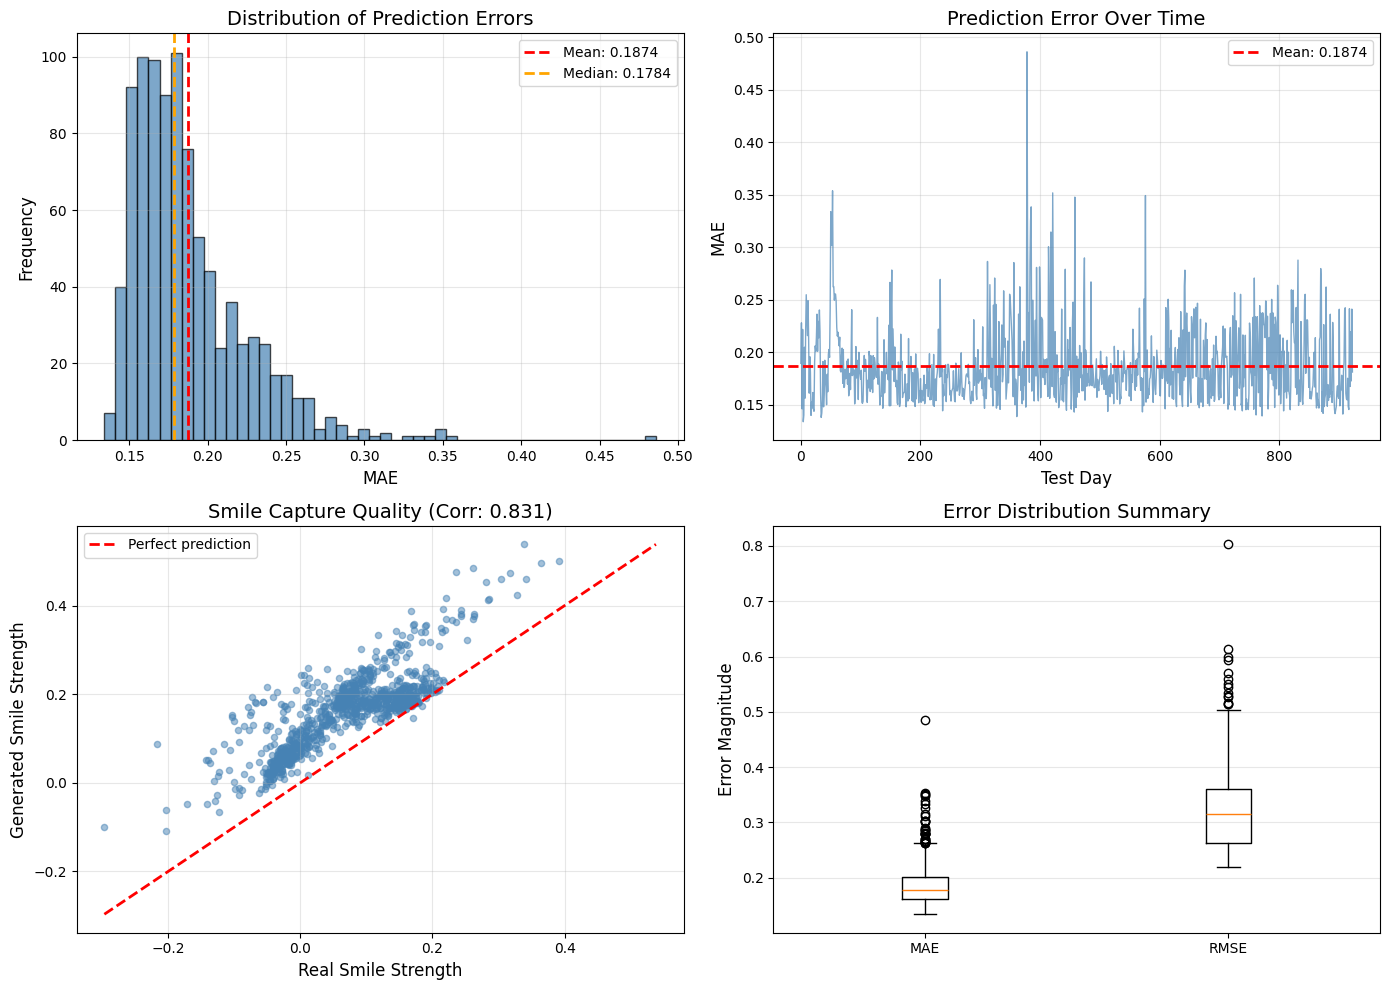


✓ Visualization saved as 'volgan_backtest_results.png'

BEST PREDICTION DAYS
1. Day 4: MAE = 0.1340
2. Day 34: MAE = 0.1381
3. Day 361: MAE = 0.1389

WORST PREDICTION DAYS
1. Day 421: MAE = 0.3518
2. Day 53: MAE = 0.3538
3. Day 378: MAE = 0.4860


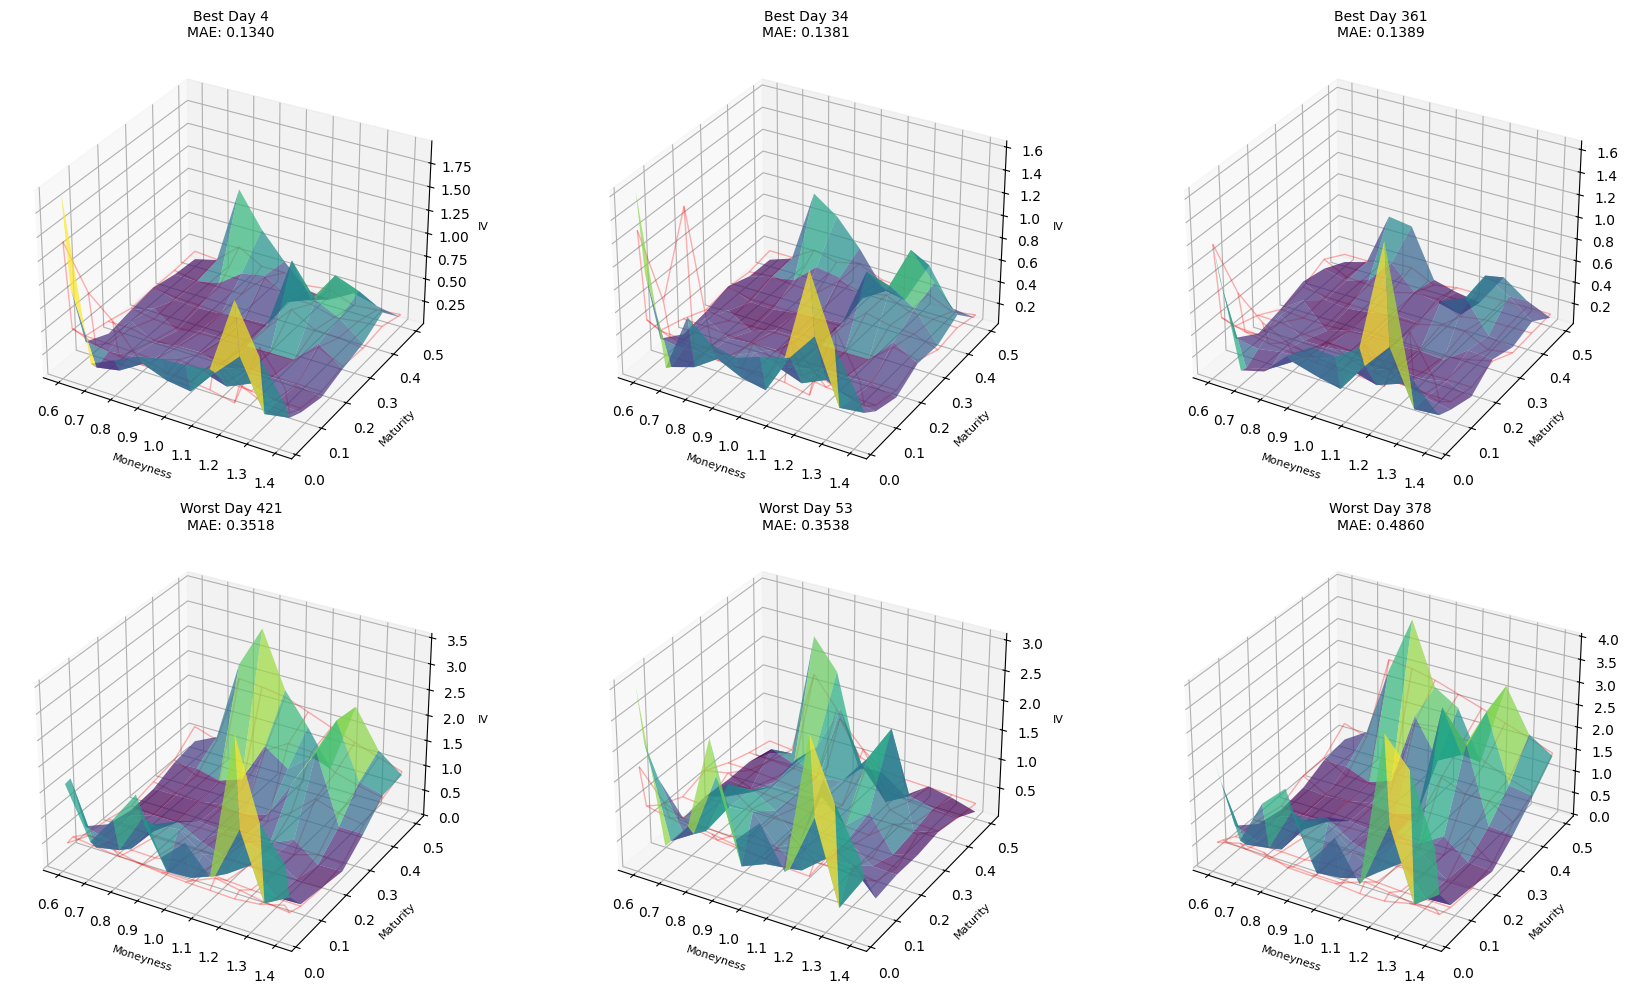


✓ Best/worst day comparison saved as 'volgan_best_worst_days.png'


In [83]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================================================================
# STEP 1: Run the backtest
# ============================================================================

def backtest_volgan(gen, condition_test, m, tau, n_samples=100, device='cpu'):
    """
    Backtest VolGAN on out-of-sample data.
    """
    gen.eval()
    n_test = condition_test.shape[0]
    
    # Storage
    mae_per_day = []
    rmse_per_day = []
    smile_strength_real = []
    smile_strength_gen = []
    
    predictions = np.zeros((n_samples, n_test, len(m) * len(tau)))
    
    print("Generating predictions for test set...")
    with torch.no_grad():
        for i in tqdm(range(n_samples)):
            noise = torch.randn((n_test, gen.noise_dim), device=device)
            fake = gen(noise, condition_test)
            
            surface_past = condition_test[:, 3:]
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            
            predictions[i, :, :] = fake_surface.cpu().numpy()
    
    # Evaluate each test day
    print("\nEvaluating predictions...")
    for day_idx in tqdm(range(n_test)):
        # Real surface
        real_surface = torch.exp(condition_test[day_idx, 3:]).cpu().numpy()
        
        # Generated surface (mean of samples)
        gen_surface = predictions[:, day_idx, :].mean(axis=0)
        
        # 1. Point-wise error
        mae = np.mean(np.abs(gen_surface - real_surface))
        rmse = np.sqrt(np.mean((gen_surface - real_surface)**2))
        mae_per_day.append(mae)
        rmse_per_day.append(rmse)
        
        # 2. Smile strength
        real_grid = real_surface.reshape(len(tau), len(m)).T  # (10, 8)
        gen_grid = gen_surface.reshape(len(tau), len(m)).T
        
        # Find ATM index
        atm_idx = np.argmin(np.abs(m - 1.0))
        
        # Smile strength = OTM put IV - ATM IV (averaged across maturities)
        real_smile_str = real_grid[0, :].mean() - real_grid[atm_idx, :].mean()
        gen_smile_str = gen_grid[0, :].mean() - gen_grid[atm_idx, :].mean()
        
        smile_strength_real.append(real_smile_str)
        smile_strength_gen.append(gen_smile_str)
    
    # Summary statistics
    metrics = {
        'mae_mean': np.mean(mae_per_day),
        'mae_std': np.std(mae_per_day),
        'mae_median': np.median(mae_per_day),
        'rmse_mean': np.mean(rmse_per_day),
        'rmse_std': np.std(rmse_per_day),
        'smile_correlation': np.corrcoef(smile_strength_real, smile_strength_gen)[0, 1],
        'smile_bias': np.mean(np.array(smile_strength_gen) - np.array(smile_strength_real)),
    }
    
    return metrics, predictions, mae_per_day, rmse_per_day, smile_strength_real, smile_strength_gen


# ============================================================================
# STEP 2: Run the backtest
# ============================================================================

print("="*60)
print("RUNNING BACKTEST")
print("="*60)

metrics, predictions, mae_per_day, rmse_per_day, smile_strength_real, smile_strength_gen = backtest_volgan(
    gen, condition_test, m, tau, 
    n_samples=100, device=device
)

# Print results
print("\n" + "="*60)
print("BACKTEST RESULTS")
print("="*60)
print(f"Test period: {len(condition_test)} days")
print(f"\nPrediction Accuracy:")
print(f"  MAE: {metrics['mae_mean']:.4f} ± {metrics['mae_std']:.4f}")
print(f"  RMSE: {metrics['rmse_mean']:.4f} ± {metrics['rmse_std']:.4f}")
print(f"  Median MAE: {metrics['mae_median']:.4f}")
print(f"\nSmile Capture:")
print(f"  Correlation: {metrics['smile_correlation']:.4f}")
print(f"  Bias: {metrics['smile_bias']:.4f}")
print("="*60)


# ============================================================================
# STEP 3: Visualize results
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE distribution
axes[0, 0].hist(mae_per_day, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.mean(mae_per_day), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(mae_per_day):.4f}')
axes[0, 0].axvline(np.median(mae_per_day), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(mae_per_day):.4f}')
axes[0, 0].set_xlabel('MAE', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Prediction Errors', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE over time
axes[0, 1].plot(mae_per_day, alpha=0.7, linewidth=1, color='steelblue')
axes[0, 1].axhline(np.mean(mae_per_day), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(mae_per_day):.4f}')
axes[0, 1].set_xlabel('Test Day', fontsize=12)
axes[0, 1].set_ylabel('MAE', fontsize=12)
axes[0, 1].set_title('Prediction Error Over Time', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Smile strength comparison
axes[1, 0].scatter(smile_strength_real, smile_strength_gen, alpha=0.5, s=20, color='steelblue')
max_smile = max(max(smile_strength_real), max(smile_strength_gen))
min_smile = min(min(smile_strength_real), min(smile_strength_gen))
axes[1, 0].plot([min_smile, max_smile], [min_smile, max_smile], 
                'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Real Smile Strength', fontsize=12)
axes[1, 0].set_ylabel('Generated Smile Strength', fontsize=12)
axes[1, 0].set_title(f'Smile Capture Quality (Corr: {metrics["smile_correlation"]:.3f})', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Error statistics box plot
error_stats = [mae_per_day, rmse_per_day]
axes[1, 1].boxplot(error_stats, labels=['MAE', 'RMSE'])
axes[1, 1].set_ylabel('Error Magnitude', fontsize=12)
axes[1, 1].set_title('Error Distribution Summary', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('volgan_backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'volgan_backtest_results.png'")


# ============================================================================
# STEP 4: Additional Analysis - Best and Worst Days
# ============================================================================

# Find best and worst prediction days
mae_array = np.array(mae_per_day)
best_days_idx = np.argsort(mae_array)[:3]
worst_days_idx = np.argsort(mae_array)[-3:]

print("\n" + "="*60)
print("BEST PREDICTION DAYS")
print("="*60)
for rank, idx in enumerate(best_days_idx, 1):
    print(f"{rank}. Day {idx}: MAE = {mae_per_day[idx]:.4f}")

print("\n" + "="*60)
print("WORST PREDICTION DAYS")
print("="*60)
for rank, idx in enumerate(worst_days_idx, 1):
    print(f"{rank}. Day {idx}: MAE = {mae_per_day[idx]:.4f}")


# ============================================================================
# STEP 5: Visual comparison of best/worst days
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

from matplotlib import cm

# Prepare meshgrid
M, T = np.meshgrid(m, tau, indexing='ij')

# Plot best days (top row)
for i, day_idx in enumerate(best_days_idx):
    real_surface = torch.exp(condition_test[day_idx, 3:]).cpu().numpy()
    gen_surface = predictions[:, day_idx, :].mean(axis=0)
    
    real_grid = real_surface.reshape(len(tau), len(m)).T
    gen_grid = gen_surface.reshape(len(tau), len(m)).T
    
    # Plot generated
    ax = axes[0, i]
    ax.plot_surface(M, T, gen_grid, cmap=cm.viridis, alpha=0.7, label='Generated')
    ax.plot_wireframe(M, T, real_grid, color='red', alpha=0.3, linewidth=1)
    ax.set_title(f'Best Day {day_idx}\nMAE: {mae_per_day[day_idx]:.4f}', fontsize=10)
    ax.set_xlabel('Moneyness', fontsize=8)
    ax.set_ylabel('Maturity', fontsize=8)
    ax.set_zlabel('IV', fontsize=8)

# Plot worst days (bottom row)
for i, day_idx in enumerate(worst_days_idx):
    real_surface = torch.exp(condition_test[day_idx, 3:]).cpu().numpy()
    gen_surface = predictions[:, day_idx, :].mean(axis=0)
    
    real_grid = real_surface.reshape(len(tau), len(m)).T
    gen_grid = gen_surface.reshape(len(tau), len(m)).T
    
    # Plot generated
    ax = axes[1, i]
    ax.plot_surface(M, T, gen_grid, cmap=cm.viridis, alpha=0.7)
    ax.plot_wireframe(M, T, real_grid, color='red', alpha=0.3, linewidth=1)
    ax.set_title(f'Worst Day {day_idx}\nMAE: {mae_per_day[day_idx]:.4f}', fontsize=10)
    ax.set_xlabel('Moneyness', fontsize=8)
    ax.set_ylabel('Maturity', fontsize=8)
    ax.set_zlabel('IV', fontsize=8)

plt.tight_layout()
plt.savefig('volgan_best_worst_days.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Best/worst day comparison saved as 'volgan_best_worst_days.png'")

In [84]:
gen.eval()
with torch.no_grad():
    # Pick a test condition
    test_condition = condition_test[0:1]  # Single condition
    noise = torch.randn((1000, noise_dim), device=device)
    condition_batch = test_condition.repeat(1000, 1)
    fake_samples = gen(noise, condition_batch).cpu().numpy()
    
    print("Generated spot returns:")
    print(f"  Mean: {fake_samples[:, 0].mean():.6f}")
    print(f"  Std: {fake_samples[:, 0].std():.6f}")
    print(f"  Min: {fake_samples[:, 0].min():.6f}")
    print(f"  Max: {fake_samples[:, 0].max():.6f}")
    print(f"  Sample values: {fake_samples[:5, 0]}")
    
    print("\nGenerated log IV increments:")
    print(f"  Mean: {fake_samples[:, 1:].mean():.6f}")
    print(f"  Std: {fake_samples[:, 1:].std():.6f}")
    print(f"  Min: {fake_samples[:, 1:].min():.6f}")
    print(f"  Max: {fake_samples[:, 1:].max():.6f}")


Generated spot returns:
  Mean: 0.352502
  Std: 0.033854
  Min: 0.250231
  Max: 0.475020
  Sample values: [0.27983463 0.3445554  0.33134854 0.36351022 0.41536146]

Generated log IV increments:
  Mean: 0.257953
  Std: 0.509969
  Min: -0.926202
  Max: 2.078188


In [85]:
# === SECTION 15: Run VolGAN Backtest ===

m0_list = [0.9,1,  1.1]


results_volgan = run_volgan_experiment(
    df_1m_bt, gen, m0_list,
    condition_test_filtered,
    dates_test_filtered,
    true_mean, true_std, m, tau, max_windows=52, device=device
)

print(f"\nVolGAN results: {results_volgan.shape}")
results_volgan.head()


===== VolGAN: m0=0.9 =====
Window 1/43
Window 2/43
Window 3/43
Window 4/43
Window 5/43
Window 6/43
Window 7/43
Window 8/43
Window 9/43
Window 10/43
Window 11/43
Window 12/43
Window 13/43
Window 14/43
Window 15/43
Window 16/43
Window 17/43
Window 18/43
Window 19/43
Window 20/43
Window 21/43
Window 22/43
Window 23/43
Window 24/43
Window 25/43
Window 26/43
Window 27/43
Window 28/43
Window 29/43
Window 30/43
Window 31/43
Window 32/43
Window 33/43
Window 34/43
Window 35/43
Window 36/43
Window 37/43
Window 38/43
Window 39/43
Window 40/43
Window 41/43
Window 42/43
Window 43/43

===== VolGAN: m0=1 =====
Window 1/43
Window 2/43
Window 3/43
Window 4/43
Window 5/43
Window 6/43
Window 7/43
Window 8/43
Window 9/43
Window 10/43
Window 11/43
Window 12/43
Window 13/43
Window 14/43
Window 15/43
Window 16/43
Window 17/43
Window 18/43
Window 19/43
Window 20/43
Window 21/43
Window 22/43
Window 23/43
Window 24/43
Window 25/43
Window 26/43
Window 27/43
Window 28/43
Window 29/43
Window 30/43
Window 31/43
Wi

,start,end,m0,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged,strategy
0,2020-01-02,2020-02-03,0.9,333.90,321.575,333.900000,-12.325000,-12.325,0.000000,VolGAN
1,2020-02-03,2020-03-04,0.9,346.35,255.850,327.494493,-71.644493,-90.500,-18.855507,VolGAN
2,2020-03-04,2020-04-02,0.9,373.50,300.200,297.510231,2.689769,-73.300,-75.989769,VolGAN
3,2020-04-02,2020-05-04,0.9,551.15,576.875,551.150000,25.725000,25.725,0.000000,VolGAN
4,2020-05-04,2020-06-03,0.9,377.30,561.000,377.300000,183.700000,183.700,0.000000,VolGAN


In [99]:
import inspect

# Get the discriminator update section
full_code = inspect.getsource(TrainLoopNoVal_corrected)

# Check for bugs
print("="*80)
print("CHECKING TRAINING LOOP FOR BUGS")
print("="*80)

# Check 1: Discriminator bias
if "+0.1" in full_code or "*0.9" in full_code:
    print("❌ BUG FOUND: Discriminator still has +0.1 or *0.9 bias!")
    print("   Search for these lines and remove +0.1 and *0.9")
    
    # Find the lines
    for i, line in enumerate(full_code.split('\n')):
        if '+0.1' in line or '*0.9' in line:
            print(f"   Line {i}: {line.strip()}")
else:
    print("✅ Discriminator bias removed")

# Check 2: Penalty scaling
if "alpha * 0.01" in full_code or "beta * 0.01" in full_code:
    print("✅ Penalties are scaled for normalized data")
elif "alpha_scaled" in full_code:
    print("✅ Penalties use scaled variables")
else:
    print("❌ WARNING: Penalties may not be scaled correctly")
    print("   Penalties should use alpha*0.01 or alpha_scaled")

# Check 3: Penalty computation
if "surface_past" in full_code and "fake[:, 1:] + surface_past" in full_code:
    print("❌ BUG FOUND: Penalties computed in log-space (requires denormalization)")
    print("   This is wrong when training on normalized data!")
elif "fake_iv_normalized" in full_code or "fake[:, 1:]" in full_code:
    print("✅ Penalties computed on normalized outputs (correct)")
else:
    print("⚠️  Cannot determine penalty computation method")

print("="*80)

CHECKING TRAINING LOOP FOR BUGS
❌ BUG FOUND: Discriminator still has +0.1 or *0.9 bias!
   Search for these lines and remove +0.1 and *0.9
   Line 41: # ✅ FIXED: No +0.1 or *0.9
✅ Penalties are scaled for normalized data
✅ Penalties computed on normalized outputs (correct)


In [87]:
noise = torch.randn((923, noise_dim), device=device)
cond = condition_test[:1000]
fake = gen(noise, cond)
returns = fake[:,0].cpu().detach().numpy()
print("returns mean/std/min/max:", returns.mean(), returns.std(), returns.min(), returns.max())


returns mean/std/min/max: 0.81343305 0.37521338 -0.11139774 1.7424911


In [88]:
# === SECTION 16: Summary Statistics ===

summary_volgan = results_volgan.groupby('m0')['tracking_error'].agg([
    'mean', 'median', 'std',
    ('VaR_5%', lambda x: x.quantile(0.05))
]).round(3)

print("\nVolGAN Tracking Error Summary:")
print(summary_volgan)


VolGAN Tracking Error Summary:
       mean  median      std   VaR_5%
m0                                   
0.9  55.467  42.000  152.307 -156.230
1.0  84.223  78.146  122.342  -87.478
1.1  -8.685 -43.650  178.672 -230.319


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29708\1997402176.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')


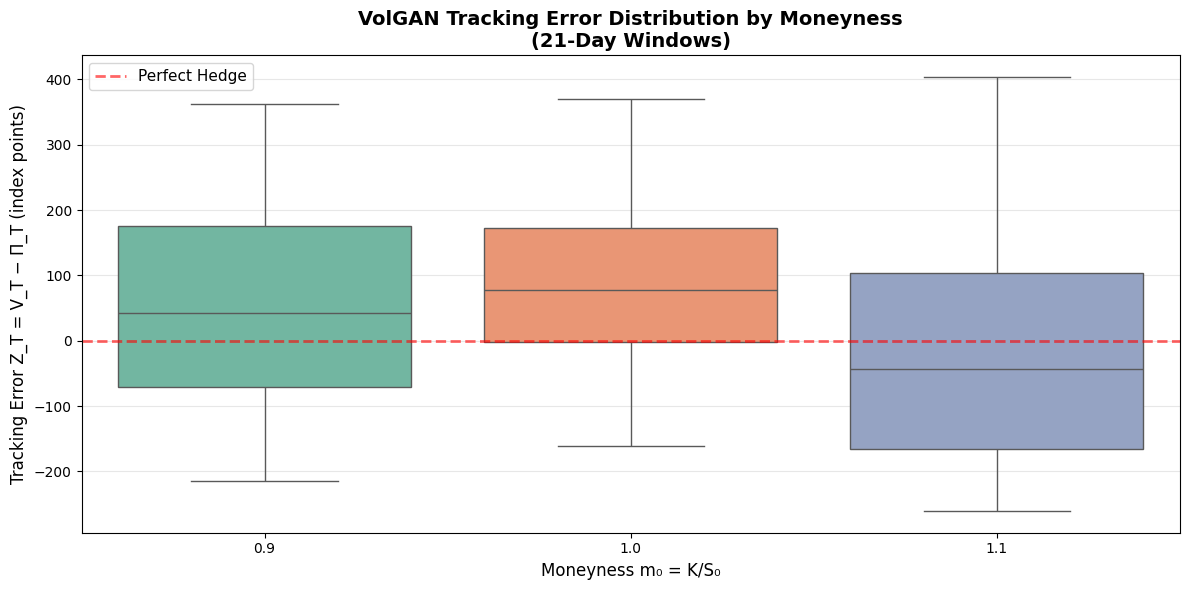

In [89]:
# === SECTION 17: VolGAN Results — Box Plot by Moneyness ===

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')
plt.title('VolGAN Tracking Error Distribution by Moneyness\n(21-Day Windows)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=12)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Perfect Hedge')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
# === SECTION 18: Summary Statistics Table ===

summary_volgan = results_volgan.groupby('m0')['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*80)
print("VolGAN Tracking Error Summary by Moneyness")
print("="*80)
print(summary_volgan)
print("="*80)


VolGAN Tracking Error Summary by Moneyness
     Count    Mean  Median  Std Dev      Min      Max   VaR 5%   VaR 1%
m0                                                                     
0.9     43  55.467  42.000  152.307 -215.400  361.700 -156.230 -191.595
1.0     43  84.223  78.146  122.342 -161.200  370.501  -87.478 -155.219
1.1     39  -8.685 -43.650  178.672 -260.716  403.604 -230.319 -250.488


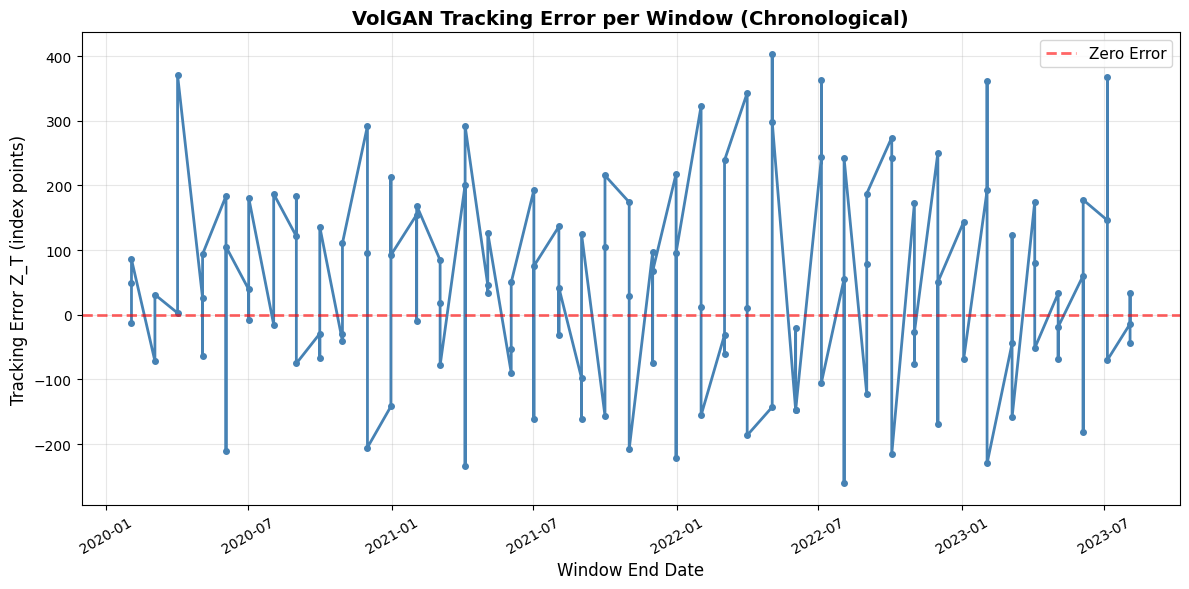

In [91]:
# === SECTION 19: Tracking Error Time Series ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['tracking_error'], marker='o', color='steelblue', 
         linewidth=2, markersize=4)
plt.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Zero Error')
plt.title('VolGAN Tracking Error per Window (Chronological)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error Z_T (index points)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

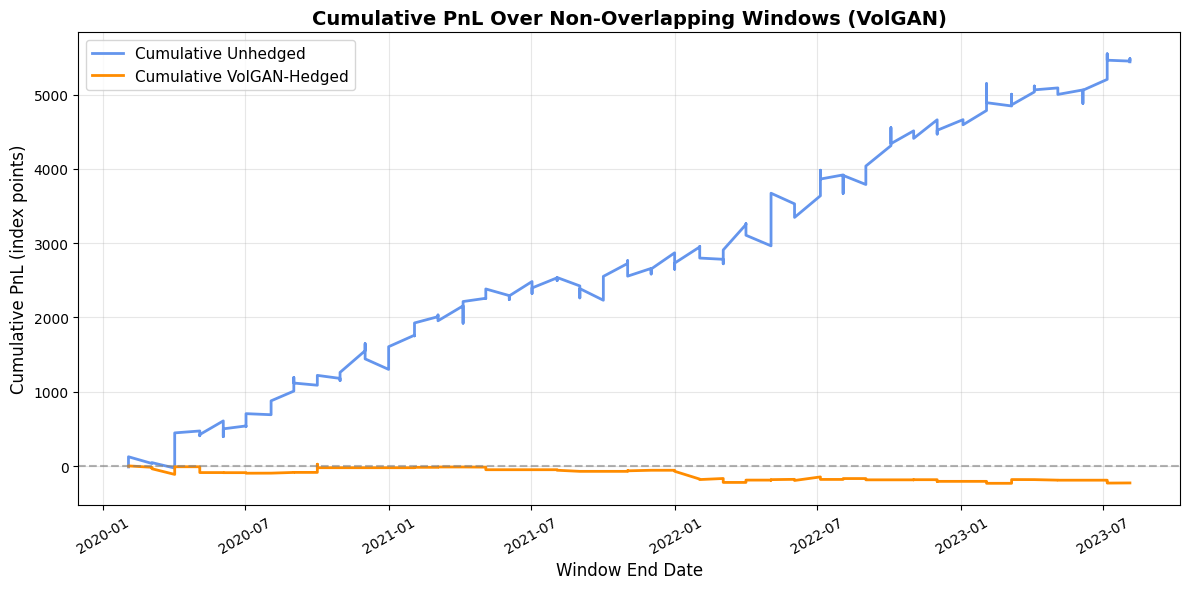

In [92]:
# === SECTION 20: Cumulative PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged'] = res['pnl_hedged'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', 
         color='cornflowerblue', linewidth=2)
plt.plot(res['end'], res['cum_hedged'], label='Cumulative VolGAN-Hedged', 
         color='darkorange', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.title('Cumulative PnL Over Non-Overlapping Windows (VolGAN)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Cumulative PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

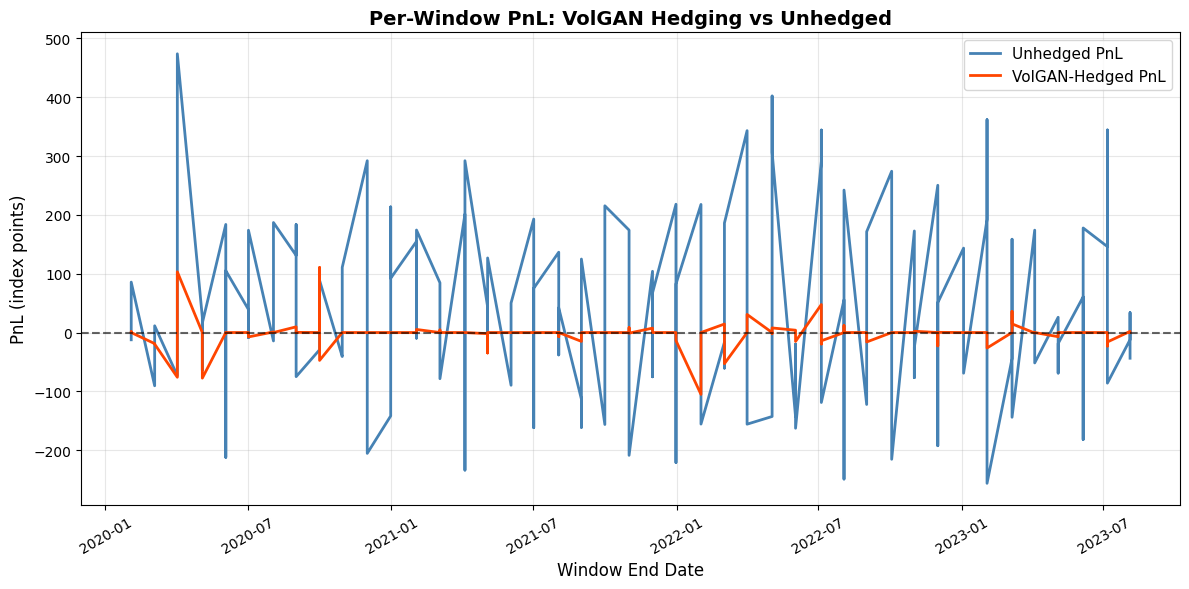

In [93]:
# === SECTION 21: Per-Window PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', 
         color='steelblue', linewidth=2)
plt.plot(res['end'], res['pnl_hedged'], label='VolGAN-Hedged PnL', 
         color='orangered', linewidth=2)
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per-Window PnL: VolGAN Hedging vs Unhedged', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




In [94]:
# Run this and share output:
# After training, verify generator quality:
gen.eval()
with torch.no_grad():
    # Generate test surfaces
    for idx in [0, 100, 200]:
        condition = condition_test[idx].unsqueeze(0)
        noise = torch.randn((1, noise_dim), device=device)
        fake = gen(noise, condition)
        
        real_surface = torch.exp(condition[0, 3:]).cpu().numpy()
        gen_surface = torch.exp(fake[0, 1:] + condition[0, 3:]).cpu().numpy()
        
        mae = np.abs(gen_surface - real_surface).mean()
        print(f"Test day {idx}: MAE = {mae:.4f}")
        
        # Should be < 0.05
        if mae > 0.10:
            print("⚠️ Generator not trained well!")
        

Test day 0: MAE = 0.1788
⚠️ Generator not trained well!
Test day 100: MAE = 0.1711
⚠️ Generator not trained well!
Test day 200: MAE = 0.1742
⚠️ Generator not trained well!


In [95]:
# save to csv
results_volgan.to_csv('results_volgan_valid.csv', index=False)
print("Delta results saved to results_volgan_valid.csv")

Delta results saved to results_volgan_valid.csv


In [96]:
# Check if you loaded an old checkpoint
print("\nGenerator state:")
print(f"Generator class: {gen.__class__.__name__}")
print(f"Generator mu_o: {gen.mu_o}")
print(f"Generator std_o: {gen.std_o}")

# Check if parameters were updated
param_sum = sum(p.sum().item() for p in gen.parameters())
print(f"Sum of all parameters: {param_sum:.6f}")


Generator state:
Generator class: Generator
Generator mu_o: False
Generator std_o: False
Sum of all parameters: 383.086467
